# <p style="text-align: center;"> Мастерская 2. Маркетинг</p>

**<span style="font-size:24px;">Описание проекта</span>**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Цель - Предсказать вероятность покупки в течение 90 дней.


**<span style="font-size:24px;">Описание данных</span>**

<span style="font-size:18px;">`purchases`</span> - Данные о покупках клиентов по дням и по товарам. В каждой записи покупка
определенного товара, его цена, количество штук.

- **client_id** - идентификатор клиента
- **quantity** - количество единиц товара
- **price** - цена товара
- **category_ids** - идентификаторы категорий
- **date дата** - покупки
- **message_id** - идентификатор сообщения из рассылки

<span style="font-size:18px;">`messages`</span> - Рассылки, которые были отправлены клиентам из таблицы покупок

- **bulk_campaign_id** -  идентификатор рассылки
- **client_id** -  идентификатор клиента
- **message_id** -  идентификатор сообщения
- **event** -  действие с сообщением (отправлено, открыто, покупка…)
- **channel** -  канал рассылки
- **date** -  дата действия
- **created_at** -  дата-время полностью

<span style="font-size:18px;">`target`</span>

- **client_id** - идентификатор клиента
- **target** - клиент совершил покупку в целевом периоде

## Импорт библиотек

In [1]:
!pip install shap -q
!pip install phik -q
!pip install catboost -q


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder                     
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTENC, ADASYN
import shap

## Собственные функции

In [3]:
# функция для просмотра информации  таблице

def df_info(df):
    df.info()
    display(df.head())
    print(f'Количевтво пропусков в столбцах:\n{df.isna().sum().sort_values(ascending=False)}')
    print(f'Колличество явных дубликатов: {df.duplicated().sum()}')
    

In [4]:
# создадим функцию для построения гистограмм и ящика с усами

def hist_box(df, column):
   
    mean = df[column].mean()
    median = df[column].median()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # гистограмма
    
    axs[0].hist(df[column], bins = 'auto')
    axs[0].set_title(f'Гистограмма для {column}', fontsize=16)
    axs[0].set_xlabel(f'Значения столбца {column}', fontsize=14)
    axs[0].set_ylabel('Количество', fontsize=14)
    axs[0].axvline(x=mean, color='red', label=f'mean: {round(df[column].mean(), 2)}')
    axs[0].axvline(x=median, color='green', label=f'median: {round(df[column].median(), 2)}')
    axs[0].legend()

    # ящик с усами 
    sns.boxplot(x=df[column], ax=axs[1])
    axs[1].set_title(f'Диаграмма размаха для {column}', fontsize=16)
    axs[1].set_xlabel(f'Значения столбца {column}', fontsize=14)

    plt.show()

In [5]:
# создадим функцию для построения столбчатой диаграммы
def bar(df, column):
    plt.figure(figsize=(17,4))
    plt.subplot()
    plt.xlabel(f'Значения столбца "{column}"', fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.title(f'Частота встречаемости "{column}"', fontsize=16)
    df[column].value_counts().plot.bar()
    for i, (df, value) in enumerate(df[column].value_counts().items()):
        plt.text(i, value -100, f'{value}', ha='center', fontsize=25) 

In [6]:
# создадим функцию для построения столбчатой диаграммы
def bar_(df, column):
    plt.figure(figsize=(17,4))
    plt.subplot()
    plt.xlabel(f'Значения столбца "{column}"', fontsize=14)
    plt.ylabel('Частота', fontsize=14)
    plt.title(f'Частота встречаемости "{column}"', fontsize=16)
    df[column].value_counts().plot.bar()
    for i, (df, value) in enumerate(df[column].value_counts(normalize = True).round(2).items()):
        plt.text(i, value -100, f'{value}', ha='center', fontsize=25) 

In [7]:
# # Создадим функцию для определения типа дня недели
# def type_day(day):
#     weekday = [0,1,2,3,4]
#     weekend = [5,6]
#     if day in weekday:
#         return 'будний'
#     elif day in weekend:
#         return 'выходной'
    


In [8]:
# Создадим функцию для определения дня и ночи
def day_night(df):
    if 8 <= df.hour < 21:
        return 'день'
    else:
        return 'ночь'


In [9]:
# Функция выбора наиболее часто встречающейся категории по группам
def most_frequent(x):
    return x.mode().iloc[0]  # выбираем первый из самых частых


## Загрузка данных

In [ ]:
purchases = pd.read_csv("apparel-purchases.csv") 

messages = pd.read_csv('apparel-messages.csv')

a_target = pd.read_csv("apparel-target_binary.csv")

# daily_event = pd.read_csv("full_campaign_daily_event.csv")

# daily_event_channe = pd.read_csv("full_campaign_daily_event_channel.csv")

In [12]:
df_info(purchases)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


Количевтво пропусков в столбцах:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64
Колличество явных дубликатов: 73020


In [13]:
df_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Количевтво пропусков в столбцах:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
Колличество явных дубликатов: 48610


In [14]:
df_info(a_target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Количевтво пропусков в столбцах:
client_id    0
target       0
dtype: int64
Колличество явных дубликатов: 0


In [15]:
# daily_event.head()

In [16]:
# daily_event_channe.head()

### Вывод этапа загрузка данных


Данные загружены успешно

В таблице **purchases**:

- 202208 строк и 6 столбцов
- Типы данных соответствую значениям(кроме столбца **date**)
- Пропуски отстутсвуют
- 73020 дубликатов

В таблице **purchases**:

- 12739798 строк и 7 столбцов
- Типы данных соответствуют значениям(кроме столбцов с датами)
- Пропуски отсутствуют
- 48610 дубликатов

В таблице **target**

- 49849 строк и 2 столбца
- Типы данных соответствуют значениям 
- Пропуски и дубликаты отсутсвуют

## Предобработка и исследовательский анализ данных

### Таблица `purchases`

#### Удаление дубликатов

Дубликаты в таблице purchases скорее всего это повторные покупки в течении дня. Возможно это были какие нибудь скидки или ошибки при оформлении заказа когда человек не правильно указал колличество товара. Чтобы избавиться от этих дубликатов просуммируем столбец quantity 

In [17]:
purchases = purchases.groupby(["client_id", "price", "category_ids", "date", "message_id"], as_index=False)["quantity"].sum()

#### Столбец **client_id**

In [18]:
print('Колличество уникальных клиентов совершавших покупки:', purchases.client_id.nunique())

Колличество уникальных клиентов совершавших покупки: 49849


#### Столбец **quantity**

In [19]:
purchases.quantity.describe()

count    129018.000000
mean          1.577447
std           0.994979
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          96.000000
Name: quantity, dtype: float64

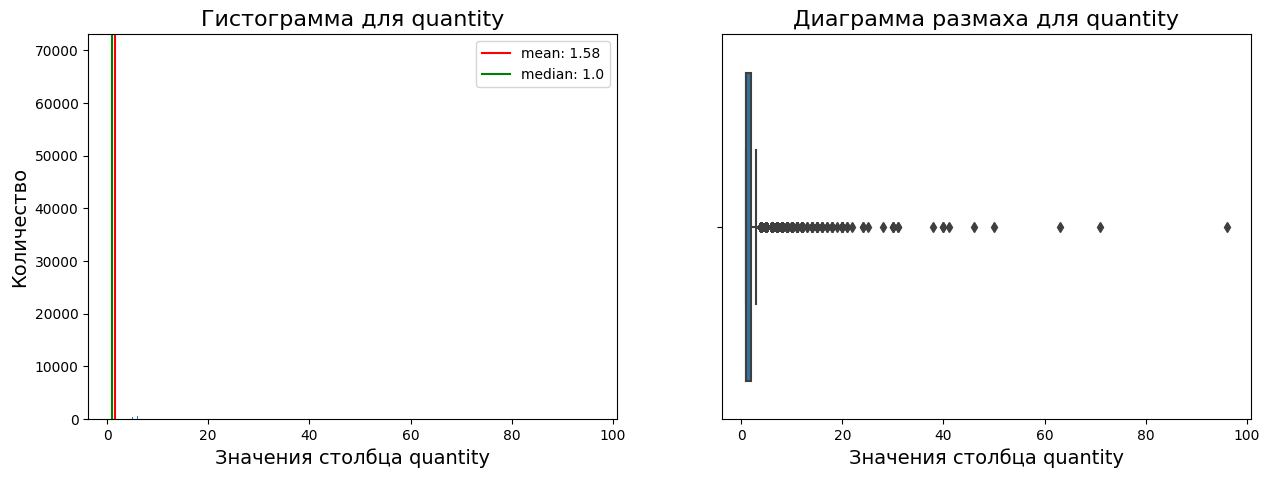

In [20]:
hist_box(purchases, 'quantity')

In [21]:
purchases = purchases[purchases.quantity < purchases.quantity.quantile(0.995)].reset_index(drop = True)

In [22]:
purchases.quantity.value_counts().sort_index()

1    69620
2    52277
3     2930
4     3038
5      312
Name: quantity, dtype: int64

Подовляющее колличество человек совершает по 1-2 покупке за раз. Есть частные случаи с большим колличеством покупок, максимально 96 за раз.

#### столбец **price**

In [23]:
purchases.price.describe()

count    128177.000000
mean       1268.905966
std        1376.956873
min           1.000000
25%         401.000000
50%         999.000000
75%        1750.000000
max       85499.000000
Name: price, dtype: float64

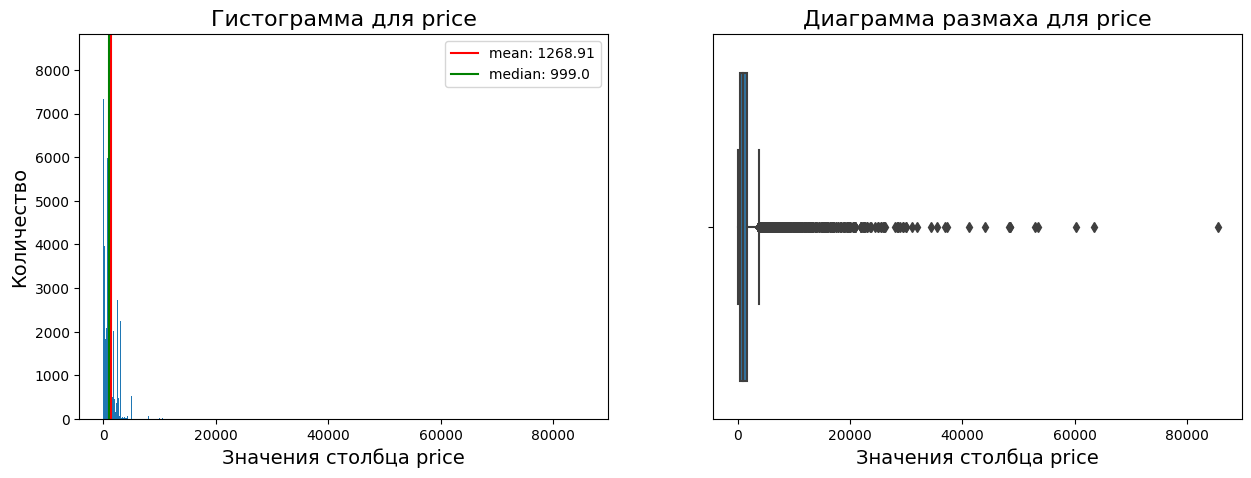

In [24]:
hist_box(purchases, 'price')

При том что 50% средних значений цены лежат в диапазоне от 399 до 1750, суммы в десятки тысяч выглядят подозрительно. Попробуем удалить 0.5% данных, что бы избавиться от выбросов. 

In [25]:
purchases = purchases[purchases.price < purchases.price.quantile(0.995)].reset_index(drop = True)

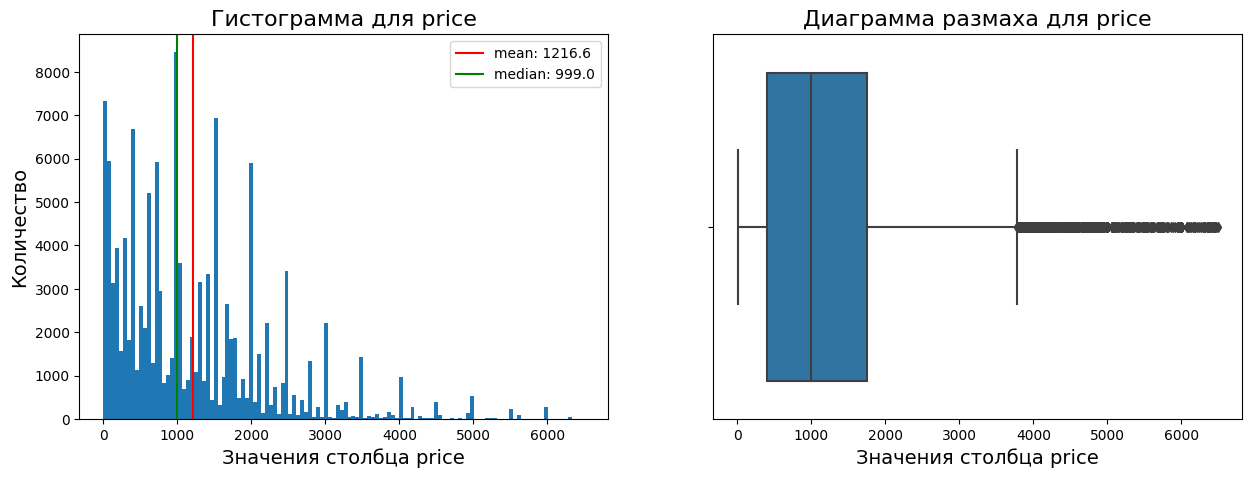

In [26]:
hist_box(purchases, 'price')

Убрав всего 0.5% данных мы избавились от выбросов. Распределение осталось скошено вправо, но хвост теперь короче

#### Столбец **category_ids**

In [27]:
purchases.category_ids.unique()

array(["['4', '27', '176', '458']", "['4', '28', '290', '422']",
       "['4', '28', '244', '432']", "['4', '27', '1828', '1599']",
       "['4', '28', '260', '420']", "['4', '28', '249', '615']",
       "['4', '28', '290', '424']", "['4', '27', '1828', '5717']", '[]',
       "['2', '18', '258', '441']", "['4', '28', '239', '418']",
       "['5562', '5630', '5699', '1829']",
       "['4', '5837', '5838', '1848']",
       "['6060', '6059', '6071', '1857']",
       "['6060', '6058', '6065', '5847']",
       "['6060', '6058', '6065', '1848']",
       "['5562', '5631', '5666', '563']", "['4', '28', '275', '421']",
       "['4', '28', '57', '431']", "['2', '18', '155', '1325']",
       "['5562', '5631', '5549', '667']", "['4', '28', '260', '1194']",
       "['4', '28', '218', '653']", "['2', '18', '212', '726']",
       "['4', '28', '124', '415']", "['5562', '5633', '5611', '713']",
       "['4', '27', '142', '496']", "['4', '28', '213', '436']",
       "['4', '28', '44', '1594']", "['4', '

Столбец включает в себя список категорий товаров. Выделим Эти категории в отдельные признаки

In [28]:
# преобразуем значения category_ids в список

purchases['category_ids'] = (purchases['category_ids'].str.strip( ) # удалим лишние пробелы вокруг
                                                      .str.replace(r'\[\]', 'None') # заменим заменим пустой список идентификаторв на None
                                                      .str.replace(r'\[|\]|\'', ' ', regex=True) # заменим лишние символы на пробелы
)

C:\Users\Александр\AppData\Local\Temp\ipykernel_3216\68738371.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  purchases['category_ids'] = (purchases['category_ids'].str.strip( ) # удалим лишние пробелы вокруг


In [29]:
# создаем столбец с первой категорией

purchases['first_category'] = (purchases['category_ids'].str.split(",", expand=True)[0] # разделим строку по запятым что бы получить список и возьмем первый элемент
                                                        .str.strip() # удалим лишние пробелы вокруг
                                                        .str.replace('None', '999') # заменим все None на новую категорию
                                                        .astype(int) # приведем к числовому значению
)

In [30]:
# создаем столбец со второй категорией

purchases['second_category'] = (purchases['category_ids'].str.split(",", expand=True)[1] # разделим строку по запятым что бы получить список и возьмем второй элемент
                                                         .astype(str) # приведем все значения к строковым
                                                         .str.replace('None', '999') # заменим все None на новую категорию
                                                         .str.strip() # удалим лишние пробелы вокруг
                                                         .astype(int) # приведем к числовому значению
)


In [31]:
# создаем столбец с третьей категорией

purchases['third_category'] = (purchases['category_ids'].str.split(",", expand=True)[2] # разделим строку по запятым что бы получить список и возьмем третий элемент
                                                         .astype(str) # приведем все значения к строковым
                                                         .str.replace('None', '999') # заменим все None на новую категорию
                                                         .str.strip() # удалим лишние пробелы вокруг
                                                         .astype(int) # приведем к числовому значению
)

In [32]:
# создаем столбец с четвертой категорией

purchases['fourth_category'] = (purchases['category_ids'].str.split(",", expand=True)[3] # разделим строку по запятым что бы получить список и возьмем третий элемент
                                                         .astype(str) # приведем все значения к строковым
                                                         .str.replace('None', '999') # заменим все None на новую категорию
                                                         .str.strip() # удалим лишние пробелы вокруг
                                                         .astype(int) # приведем к числовому значению
)

In [33]:
# создаем столбец с пятой категорией

purchases['fifth_category'] = (purchases['category_ids'].str.split(",", expand=True)[4] # разделим строку по запятым что бы получить список и возьмем третий элемент
                                                         .astype(str) # приведем все значения к строковым
                                                         .str.replace('None', '999') # заменим все None на новую категорию
                                                         .str.strip() # удалим лишние пробелы вокруг
                                                         .astype(int) # приведем к числовому значению
)

In [34]:
# удалим исходный признак category_ids

purchases = purchases.drop(columns='category_ids')

#### Столбец **date**

In [35]:
print(f"Самая раняя дата покупки: {purchases['date'].min()}  \nСамая поздняя дата покупки: {purchases['date'].max()}")

Самая раняя дата покупки: 2022-05-16  
Самая поздняя дата покупки: 2024-02-16


In [36]:
# преобразуем тип данных 

purchases['date'] = pd.to_datetime(purchases['date'], format='%Y-%m-%d')


Данные предоставлены за 21 месяц с мая 2022 по февраль 2024. 

In [37]:
# Проверим изменения после группировки и выделения новых признаков

df_info(purchases)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127486 entries, 0 to 127485
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   client_id        127486 non-null  int64         
 1   price            127486 non-null  float64       
 2   date             127486 non-null  datetime64[ns]
 3   message_id       127486 non-null  object        
 4   quantity         127486 non-null  int64         
 5   first_category   127486 non-null  int32         
 6   second_category  127486 non-null  int32         
 7   third_category   127486 non-null  int32         
 8   fourth_category  127486 non-null  int32         
 9   fifth_category   127486 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(5), int64(2), object(1)
memory usage: 7.3+ MB


,client_id,price,date,message_id,quantity,first_category,second_category,third_category,fourth_category,fifth_category
0,1515915625468060902,199.0,2022-05-27,1515915625468060902-4617-6290657dac196,2,4,27,176,458,999
1,1515915625468060902,299.0,2022-05-27,1515915625468060902-4617-6290657dac196,1,4,28,290,422,999
2,1515915625468060902,999.0,2022-05-27,1515915625468060902-4617-6290657dac196,1,4,28,244,432,999
3,1515915625468060902,1299.0,2022-05-27,1515915625468060902-4617-6290657dac196,1,4,27,1828,1599,999
4,1515915625468060902,1999.0,2022-05-27,1515915625468060902-4617-6290657dac196,2,4,28,260,420,999


Количевтво пропусков в столбцах:
client_id          0
price              0
date               0
message_id         0
quantity           0
first_category     0
second_category    0
third_category     0
fourth_category    0
fifth_category     0
dtype: int64
Колличество явных дубликатов: 4


In [38]:
# Удалим образовавшиеся дубликаты

purchases = purchases.drop_duplicates()

#### Создание новых признаков

In [39]:
# Создадим сгруппированную по клиентам таблицу

purchases_grouped = (purchases.drop(columns = ['date', 'message_id', 'first_category', 'second_category', 
                                              'third_category', 'fourth_category', 'fifth_category'])
                                              .groupby(by='client_id') # сгруппируем по клиентам
                                              .sum().reset_index())    # суммируем оставшиеся признаки quantity и price

In [40]:
purchases_grouped = purchases_grouped.rename(columns={'price' : 'total_price'})

In [41]:
# Добавим признак со средней ценой покупки

purchases_grouped['mean_price'] = round(purchases_grouped['total_price'] / purchases_grouped['quantity'], 2)

In [42]:
# Добавим признаки с датой первой и последней покупки

purchases_grouped['first_purch'] = (purchases.drop(columns = ['price', 'quantity', 'message_id', 'first_category', 
                                                             'second_category', 'third_category', 'fourth_category', 'fifth_category'])
                                                             .groupby(by='client_id', as_index=False)
                                                             .min())['date']


purchases_grouped['lust_purch'] = (purchases.drop(columns = ['price', 'quantity', 'message_id', 'first_category', 
                                                             'second_category', 'third_category', 'fourth_category', 'fifth_category'])
                                                             .groupby(by='client_id', as_index=False)
                                                             .max())['date']

In [43]:
# Добавим в сгруппированную таблицу признаки с категориями выбрав наиболее часто встречающееся значения

purchases_grouped['favorite_first_cat'] = (purchases.drop(columns = ['price', 'quantity', 'message_id', 'date', 
                                                                    'second_category', 'third_category', 'fourth_category', 'fifth_category'])
                                                                    .groupby(by='client_id', as_index=False)
                                                                    .agg(most_frequent))['first_category']


purchases_grouped['favorite_second_cat'] = (purchases.drop(columns = ['price', 'quantity', 'message_id', 'date', 
                                                                    'first_category', 'third_category', 'fourth_category', 'fifth_category'])
                                                                    .groupby(by='client_id', as_index=False)
                                                                    .agg(most_frequent))['second_category']


purchases_grouped['favorite_third_cat'] = (purchases.drop(columns = ['price', 'quantity', 'message_id', 'date', 
                                                                    'first_category', 'second_category', 'fourth_category', 'fifth_category'])
                                                                    .groupby(by='client_id', as_index=False)
                                                                    .agg(most_frequent))['third_category']


purchases_grouped['favorite_fourth_cat'] = (purchases.drop(columns = ['price', 'quantity', 'message_id', 'date', 
                                                                    'first_category', 'second_category', 'third_category', 'fifth_category'])
                                                                    .groupby(by='client_id', as_index=False)
                                                                    .agg(most_frequent))['fourth_category']


purchases_grouped['favorite_fifth_cat'] = (purchases.drop(columns = ['price', 'quantity', 'message_id', 'date', 
                                                                    'first_category', 'second_category', 'third_category', 'fourth_category'])
                                                                    .groupby(by='client_id', as_index=False)
                                                                    .agg(most_frequent))['fifth_category']

In [44]:
# Извлечем из дат первой и последней покупки день месяц и год в новые признаки

purchases_grouped['year_of_first_purch'] = pd.DatetimeIndex(purchases_grouped.first_purch).year

purchases_grouped['year_of_lust_purch'] = pd.DatetimeIndex(purchases_grouped.lust_purch).year

purchases_grouped['month_of_first_purch'] = pd.DatetimeIndex(purchases_grouped.first_purch).month

purchases_grouped['month_of_lust_purch'] = pd.DatetimeIndex(purchases_grouped.lust_purch).month

purchases_grouped['day_of_first_purch'] = pd.DatetimeIndex(purchases_grouped.first_purch).day

purchases_grouped['day_of_lust_purch'] = pd.DatetimeIndex(purchases_grouped.lust_purch).day


In [45]:
# добавим признак с колличеством дней между первой и последней покупкой

purchases_grouped['days'] = (purchases_grouped['lust_purch'] - purchases_grouped['first_purch']).dt.days + 1

In [46]:
# удалим исходные признаки с датами

purchases_grouped = purchases_grouped.drop(columns = ['first_purch', 'lust_purch'])

In [47]:
# Рассммотрим получившуюся таблицу

df_info(purchases_grouped)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49444 entries, 0 to 49443
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             49444 non-null  int64  
 1   total_price           49444 non-null  float64
 2   quantity              49444 non-null  int64  
 3   mean_price            49444 non-null  float64
 4   favorite_first_cat    49444 non-null  int32  
 5   favorite_second_cat   49444 non-null  int32  
 6   favorite_third_cat    49444 non-null  int32  
 7   favorite_fourth_cat   49444 non-null  int32  
 8   favorite_fifth_cat    49444 non-null  int32  
 9   year_of_first_purch   49444 non-null  int64  
 10  year_of_lust_purch    49444 non-null  int64  
 11  month_of_first_purch  49444 non-null  int64  
 12  month_of_lust_purch   49444 non-null  int64  
 13  day_of_first_purch    49444 non-null  int64  
 14  day_of_lust_purch     49444 non-null  int64  
 15  days               

,client_id,total_price,quantity,mean_price,favorite_first_cat,favorite_second_cat,favorite_third_cat,favorite_fourth_cat,favorite_fifth_cat,year_of_first_purch,year_of_lust_purch,month_of_first_purch,month_of_lust_purch,day_of_first_purch,day_of_lust_purch,days
0,1515915625468060902,4795.0,7,685.00,4,28,176,420,999,2022,2022,5,5,27,27,1
1,1515915625468061003,14135.0,7,2019.29,4,28,249,615,999,2023,2023,1,1,4,4,1
2,1515915625468061099,299.0,1,299.00,4,28,290,424,999,2022,2022,5,5,17,17,1
3,1515915625468061100,1049.0,2,524.50,4,27,1828,5717,999,2024,2024,2,2,10,10,1
4,1515915625468061170,14102.0,19,742.21,4,28,260,420,999,2023,2023,3,6,26,17,84


Количевтво пропусков в столбцах:
client_id               0
total_price             0
quantity                0
mean_price              0
favorite_first_cat      0
favorite_second_cat     0
favorite_third_cat      0
favorite_fourth_cat     0
favorite_fifth_cat      0
year_of_first_purch     0
year_of_lust_purch      0
month_of_first_purch    0
month_of_lust_purch     0
day_of_first_purch      0
day_of_lust_purch       0
days                    0
dtype: int64
Колличество явных дубликатов: 0


Вывод по таблице **purchases**

Для удаления дубликатов проссумировали столбец с колличеством покупок по клиентам

Удалили 1% даннных чтобы избавиться от аномальных значений в столбце *price* и *quantity*

Из столбца *category_ids* со списком категорий извлекли 5 категорий в отдельные признаки

Сгруппировали таблицу по клиентам со следующими признаками:

- *total_price* - сумма всех покупок клиента
- *quantity* - колличество покупок клиента
- *mean_price* - средняя цена покупки
- *favorite_first_cat* - *favorite_fifth_cat - любимая категория
- *year_of_first(last)_purch* - год первой(последней) покупки
- *month_of_first(last)_purch* - месяц первой(последней) покупки
- *day_of_first(last)_purch* - день первой(последней) покупки
- *days* - колличество дней между первой и последней покупкой

### Таблица `messages`


In [48]:
df_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


Количевтво пропусков в столбцах:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
Колличество явных дубликатов: 48610


#### Удаление дубликатов

В таблице присутствует столбец с датой точностью до секунды поэтому дубликаты в этой таблице действительно являются дубликатами, удалим их.

In [49]:
messages = messages.drop_duplicates()

#### Столбец **bulk_camaign_id**

In [50]:
print('Колличество уникальных значений id сообщений:', messages.bulk_campaign_id.nunique())

Колличество уникальных значений id сообщений: 2709


#### Столбец **client_id**

In [51]:
print('Колличество уникальных клиентов получивших сообщение:', messages.client_id.nunique())


Колличество уникальных клиентов получивших сообщение: 53329


#### Столбец **event**

In [52]:
messages.event.unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

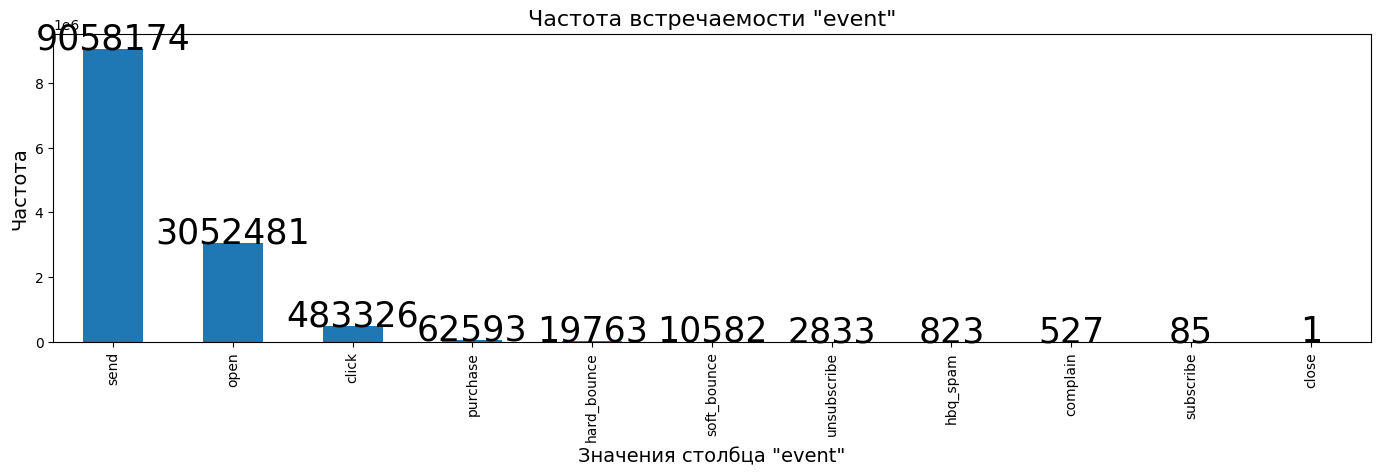

In [53]:
bar(messages, 'event')

24% клиентов открыли сообщение, 4% перешли по ссылке, 1% совершили покупки. Целых 71% сообщений были проигнорированны.

#### Столбец **channel**

In [54]:
messages.channel.unique()

array(['email', 'mobile_push'], dtype=object)

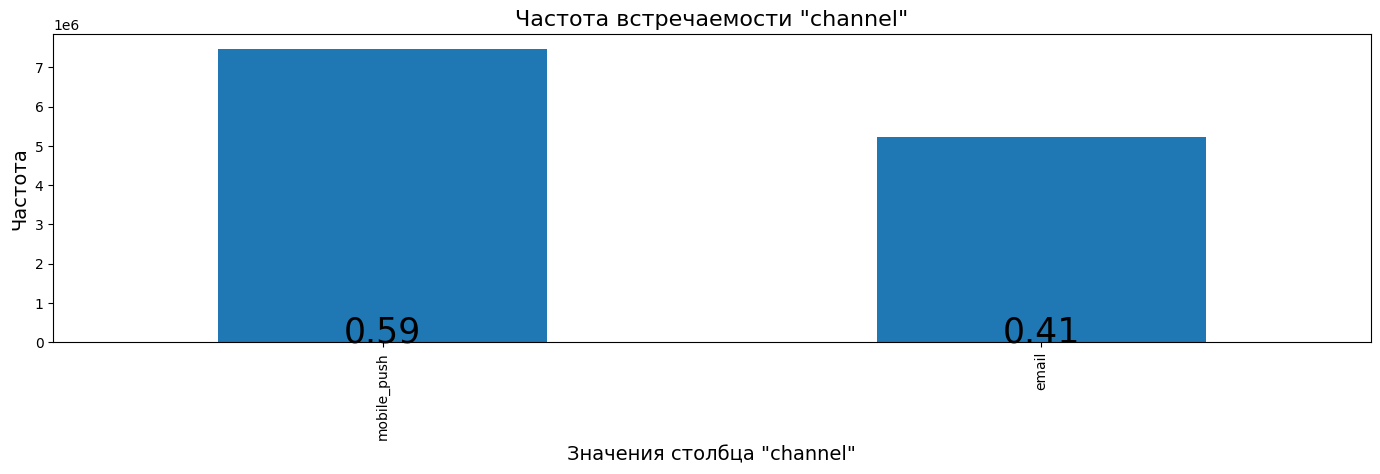

In [55]:
bar_(messages, 'channel')

#### Столбцы **date** и **created_at**

In [56]:
print(f"Самая раняя дата: {messages['date'].min()}  \nСамая поздняя дата: {messages['date'].max()}")

Самая раняя дата: 2022-05-19  
Самая поздняя дата: 2024-02-15


In [57]:
print(f"Самая раняя дата: {messages['created_at'].min()}  \nСамая поздняя дата: {messages['created_at'].max()}")

Самая раняя дата: 2022-05-19 00:14:20  
Самая поздняя дата: 2024-02-15 23:58:40


In [58]:
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')
messages['created_at'] = pd.to_datetime(messages['created_at'], format='%Y-%m-%d %H:%M:%S')

In [59]:
messages['full_date'] = messages.created_at.dt.date # создадим копию столбца created_at, но оставим только дату
messages.query('date != full_date') # проверим совпадают ли даты

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,full_date


В таблице нет ни одно строки где даты в столбцах **date** и **created_at** не совпадали бы. удалим лишние столбцы

In [60]:
messages = messages.drop(columns=['date', 'full_date'])

#### Создание новых признаков

In [61]:
# создадим столбец с днями недели 
messages['day_of_week'] = messages.created_at.dt.weekday

# создадим столбец с временем суток
messages['time_of_day'] = messages.created_at.apply(day_night)

In [62]:
# удалим исходный столбец

messages = messages.drop(columns=['created_at'])

Столбец **message_id** для решения задачи на не понадобятся удалим его

In [63]:
messages = messages.drop(columns=['message_id'])

In [64]:
messages.head()

,bulk_campaign_id,client_id,event,channel,day_of_week,time_of_day
0,4439,1515915625626736623,open,email,3,ночь
1,4439,1515915625490086521,open,email,3,ночь
2,4439,1515915625553578558,open,email,3,ночь
3,4439,1515915625553578558,click,email,3,ночь
4,4439,1515915625471518311,open,email,3,ночь


In [65]:

# Группируем по client_id и применяем функцию к остальным столбцам
messages_grouped = messages.groupby('client_id').agg(most_frequent).reset_index()

In [66]:
df_info(messages_grouped)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         53329 non-null  int64 
 1   bulk_campaign_id  53329 non-null  int64 
 2   event             53329 non-null  object
 3   channel           53329 non-null  object
 4   day_of_week       53329 non-null  int64 
 5   time_of_day       53329 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.4+ MB


,client_id,bulk_campaign_id,event,channel,day_of_week,time_of_day
0,1515915625468060902,4617,send,email,4,день
1,1515915625468061003,9148,send,email,4,день
2,1515915625468061099,9945,send,email,4,день
3,1515915625468061100,14280,send,mobile_push,3,день
4,1515915625468061170,11144,send,email,3,день


Количевтво пропусков в столбцах:
client_id           0
bulk_campaign_id    0
event               0
channel             0
day_of_week         0
time_of_day         0
dtype: int64
Колличество явных дубликатов: 0


Вывод таблицы `messages`

Удалили дубликаты

Удалили столбец *date* так как он совпадал со столбцом *created_at*

Удалили столбцы *bulk_campaign_id* и *message_id* 

Создали столбец *day_of_week* с днями недели где 0-понедельник, 7- воскресенье

Создали столбец *time_of_day* с временем суток (ночь/день) когда пришло сообщение

Сгруппировали по клиентам. 

### Таблица `a_target`

#### Столбец **client_id**

In [67]:
print('Колличество уникальных клиентов:', a_target.client_id.nunique())

Колличество уникальных клиентов: 49849


#### Столбец **target**

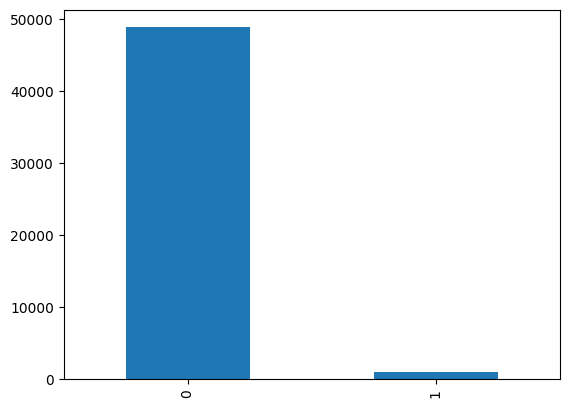

In [68]:
a_target.target.value_counts().plot.bar();

Данные сильно разбалансированы

### Итоговая таблица

In [ ]:
# столбец client_id сделаем признаком
purchases_grouped = purchases_grouped.set_index('client_id')
messages_grouped = messages_grouped.set_index('client_id')
a_target = a_target.set_index('client_id')



In [89]:

# объединим тадблицы в одну
df  = purchases_grouped.join([messages_grouped, a_target], how = 'left')

In [90]:
df_info(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49444 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_price           49444 non-null  float64
 1   quantity              49444 non-null  float64
 2   mean_price            49444 non-null  float64
 3   favorite_first_cat    49444 non-null  float64
 4   favorite_second_cat   49444 non-null  float64
 5   favorite_third_cat    49444 non-null  float64
 6   favorite_fourth_cat   49444 non-null  float64
 7   favorite_fifth_cat    49444 non-null  float64
 8   year_of_first_purch   49444 non-null  float64
 9   year_of_lust_purch    49444 non-null  float64
 10  month_of_first_purch  49444 non-null  float64
 11  month_of_lust_purch   49444 non-null  float64
 12  day_of_first_purch    49444 non-null  float64
 13  day_of_lust_purch     49444 non-null  float64
 14  days                  49444 non-null  

,total_price,quantity,mean_price,favorite_first_cat,favorite_second_cat,favorite_third_cat,favorite_fourth_cat,favorite_fifth_cat,year_of_first_purch,year_of_lust_purch,...,month_of_lust_purch,day_of_first_purch,day_of_lust_purch,days,bulk_campaign_id,event,channel,day_of_week,time_of_day,target
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,4795.0,7.0,685.00,4.0,28.0,176.0,420.0,999.0,2022.0,2022.0,...,5.0,27.0,27.0,1.0,4617.0,send,email,4.0,день,0.0
1515915625468061003,14135.0,7.0,2019.29,4.0,28.0,249.0,615.0,999.0,2023.0,2023.0,...,1.0,4.0,4.0,1.0,9148.0,send,email,4.0,день,1.0
1515915625468061099,299.0,1.0,299.00,4.0,28.0,290.0,424.0,999.0,2022.0,2022.0,...,5.0,17.0,17.0,1.0,9945.0,send,email,4.0,день,0.0
1515915625468061100,1049.0,2.0,524.50,4.0,27.0,1828.0,5717.0,999.0,2024.0,2024.0,...,2.0,10.0,10.0,1.0,14280.0,send,mobile_push,3.0,день,0.0
1515915625468061170,14102.0,19.0,742.21,4.0,28.0,260.0,420.0,999.0,2023.0,2023.0,...,6.0,26.0,17.0,84.0,11144.0,send,email,3.0,день,0.0


Количевтво пропусков в столбцах:
time_of_day             7787
day_of_week             7787
channel                 7787
event                   7787
bulk_campaign_id        7787
total_price                0
month_of_lust_purch        0
days                       0
day_of_lust_purch          0
day_of_first_purch         0
month_of_first_purch       0
quantity                   0
year_of_lust_purch         0
year_of_first_purch        0
favorite_fifth_cat         0
favorite_fourth_cat        0
favorite_third_cat         0
favorite_second_cat        0
favorite_first_cat         0
mean_price                 0
target                     0
dtype: int64
Колличество явных дубликатов: 315


В столбцах из таблицы `messages_grouped` оказалось 7787 пропущенных значений вероятно в таблице была информация не обовсех клиентах из таблиц `purchases` и `target`. Удалим пропуски и дубликаты.

In [91]:
df = df.dropna()
df = df.drop_duplicates()

In [109]:
df.describe()

,total_price,quantity,mean_price,favorite_first_cat,favorite_second_cat,favorite_third_cat,favorite_fourth_cat,favorite_fifth_cat,year_of_lust_purch,month_of_lust_purch,day_of_lust_purch,days,bulk_campaign_id,day_of_week,target
count,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000,41415.000000
mean,3165.001207,3.880357,1130.784868,1203.053845,1245.052396,1363.136255,744.723071,997.278691,2022.565133,7.058843,15.439986,23.871906,10112.270989,3.440565,0.020307
std,3537.756966,4.732809,917.885680,2300.090543,2305.542366,2224.065454,804.334648,30.212503,0.591917,3.058640,8.787655,80.559112,3940.415743,0.927510,0.141049
min,1.000000,1.000000,0.200000,1.000000,12.000000,38.000000,387.000000,467.000000,2022.000000,1.000000,1.000000,1.000000,563.000000,0.000000,0.000000
25%,1172.500000,1.000000,459.600000,4.000000,28.000000,124.000000,431.000000,999.000000,2022.000000,5.000000,8.000000,1.000000,5785.000000,3.000000,0.000000
50%,2099.000000,2.000000,899.330000,4.000000,28.000000,258.000000,496.000000,999.000000,2023.000000,7.000000,15.000000,1.000000,11209.000000,4.000000,0.000000
75%,3924.500000,4.000000,1549.000000,4.000000,31.000000,343.000000,661.000000,999.000000,2023.000000,9.000000,23.000000,1.000000,14272.000000,4.000000,0.000000
max,122772.000000,131.000000,6450.000000,6060.000000,6059.000000,6309.000000,6296.000000,999.000000,2024.000000,12.000000,31.000000,637.000000,14656.000000,6.000000,1.000000


In [116]:
df.favorite_fifth_cat.nunique()

2

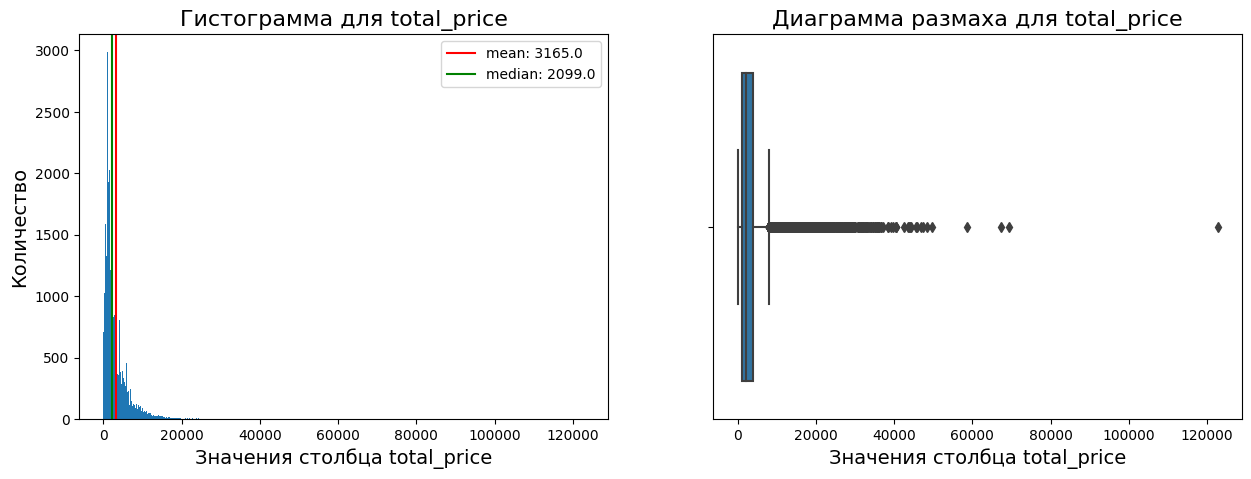

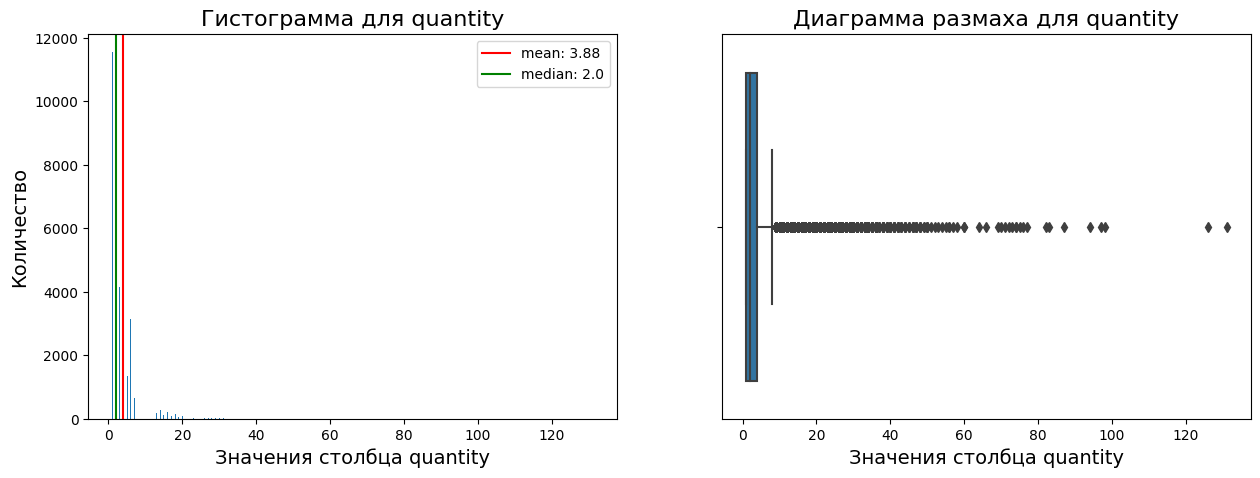

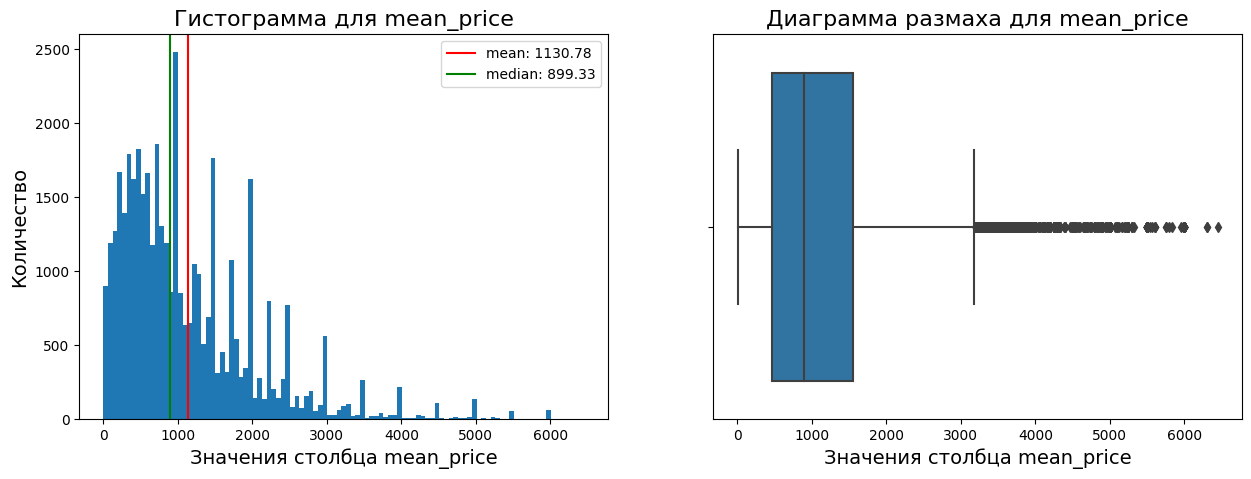

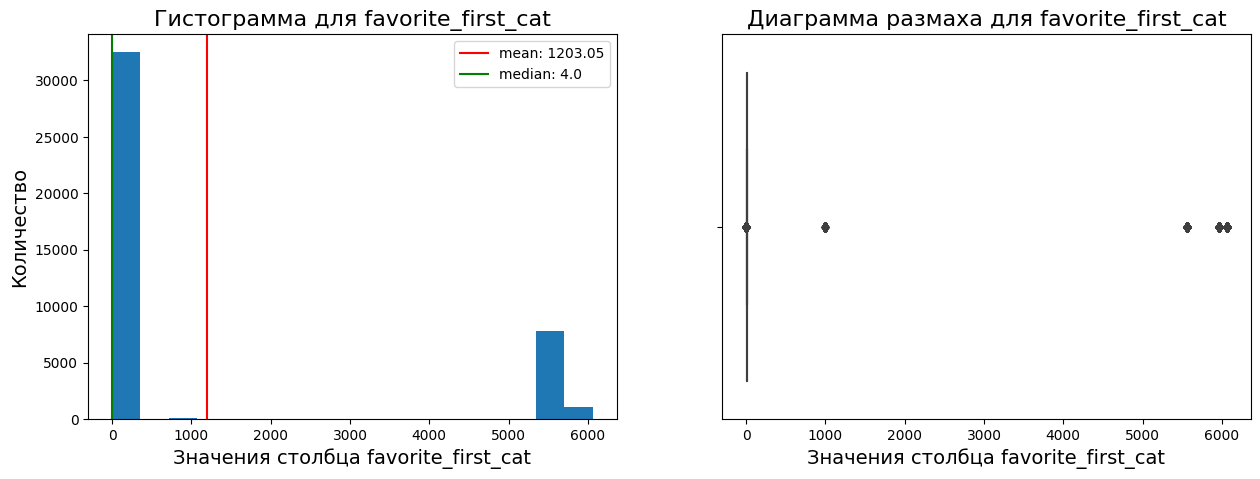

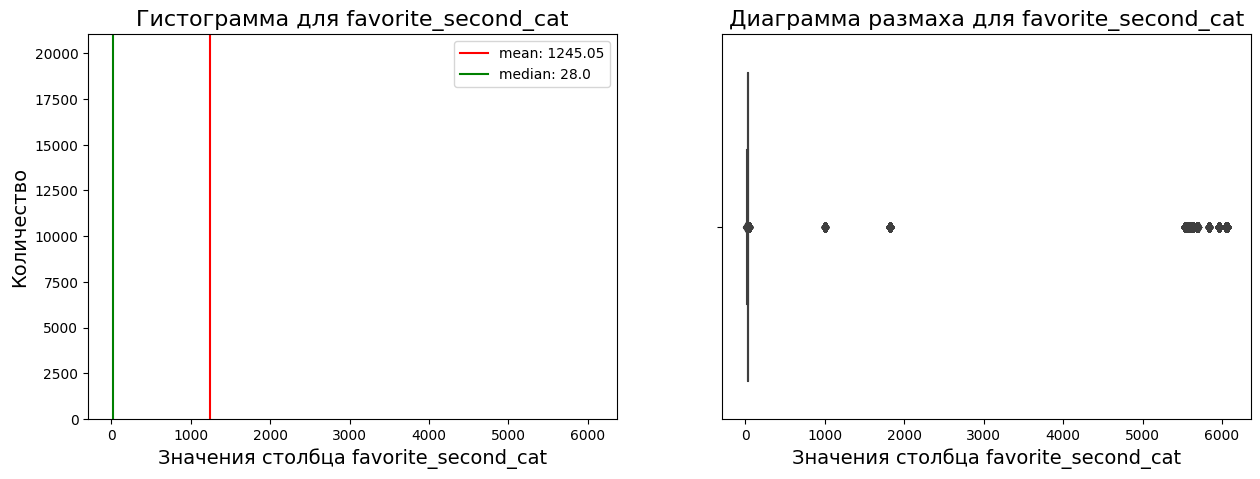

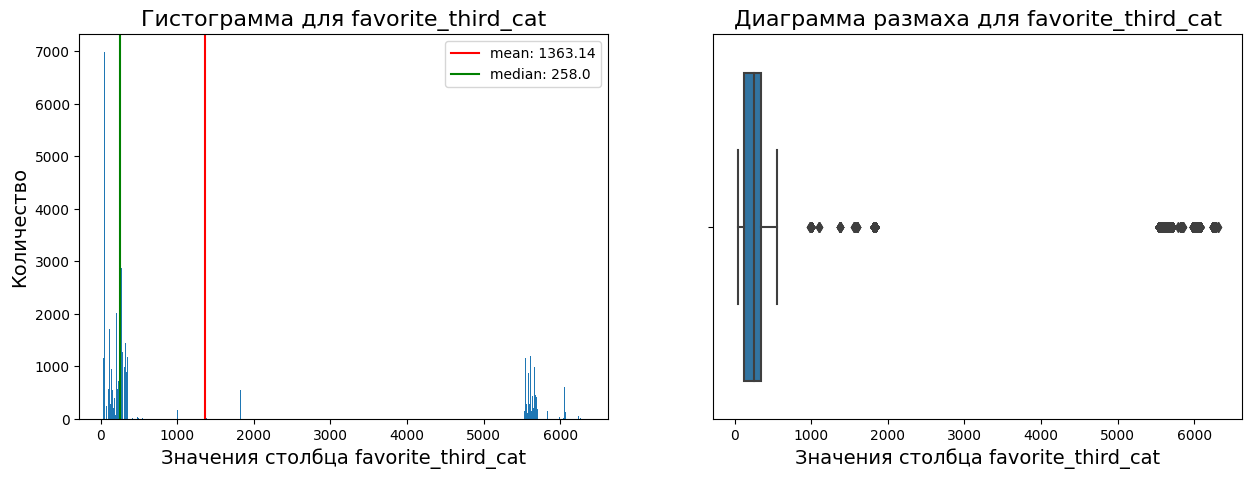

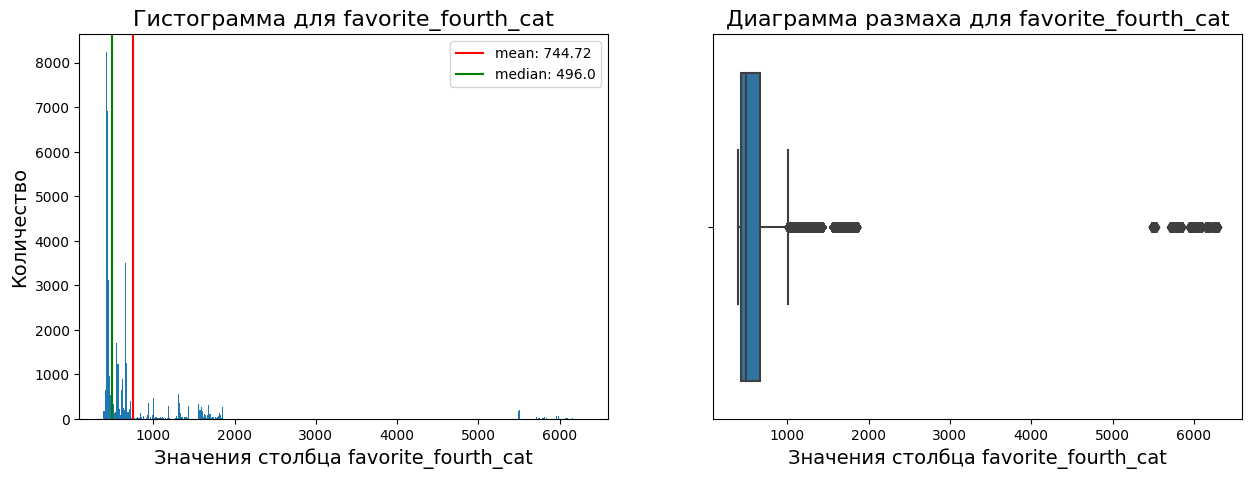

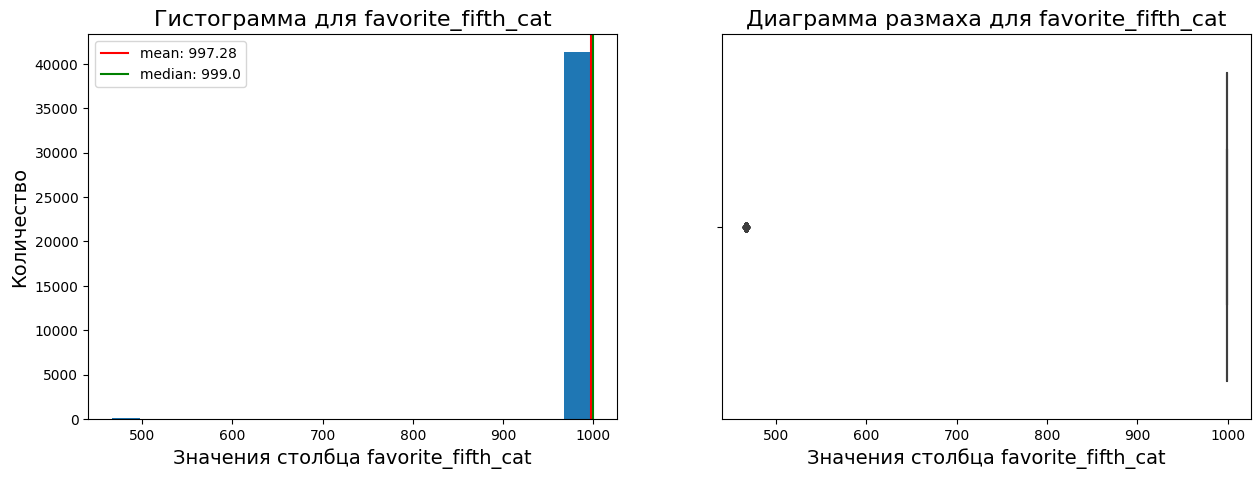

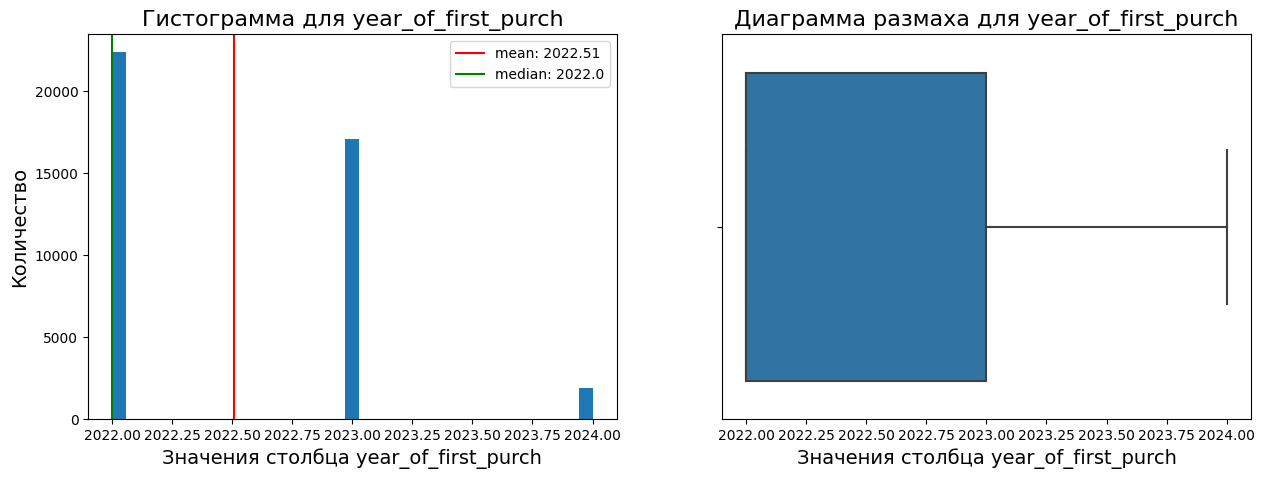

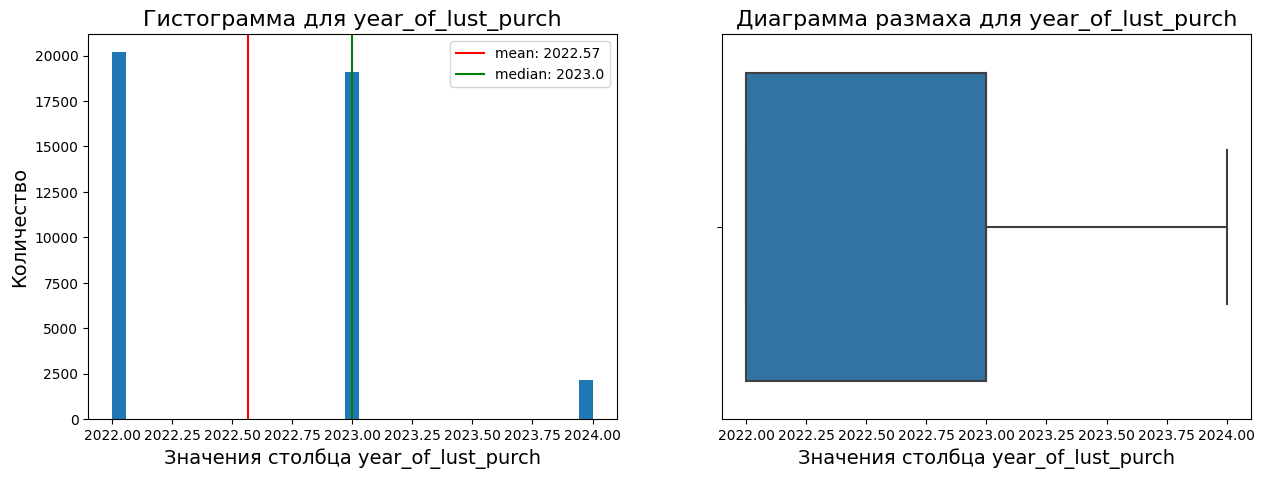

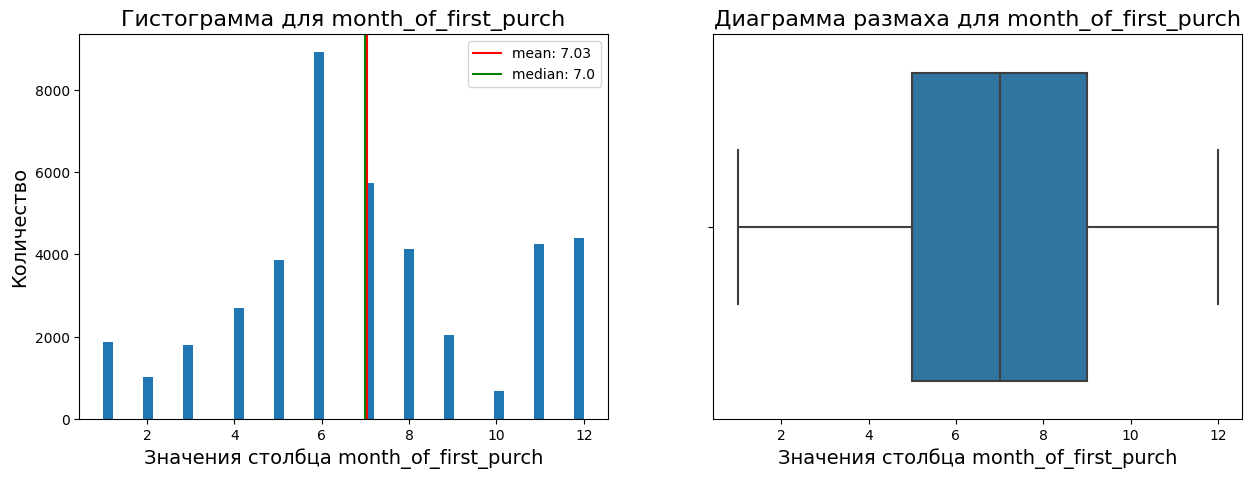

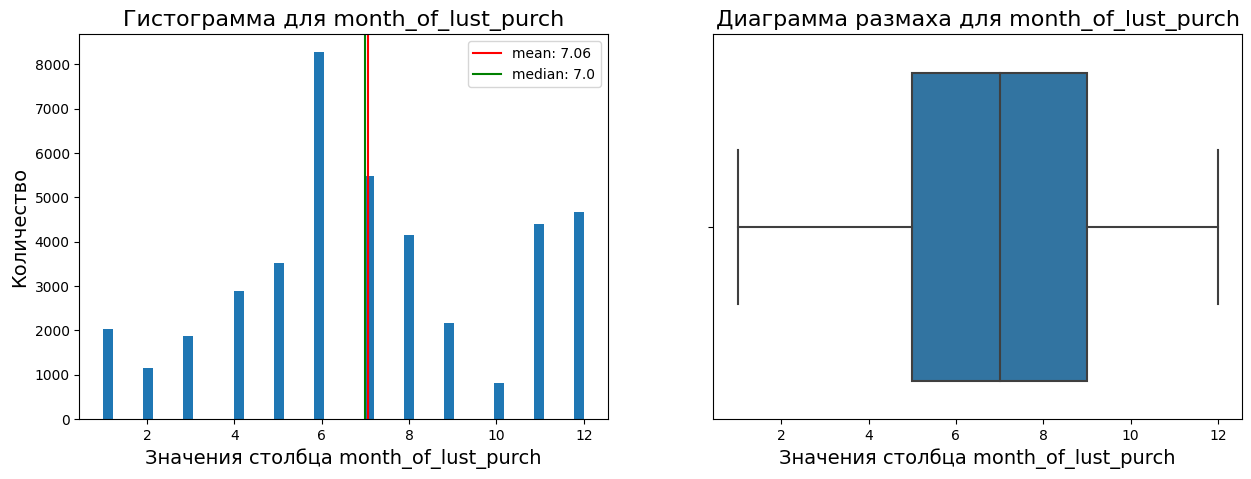

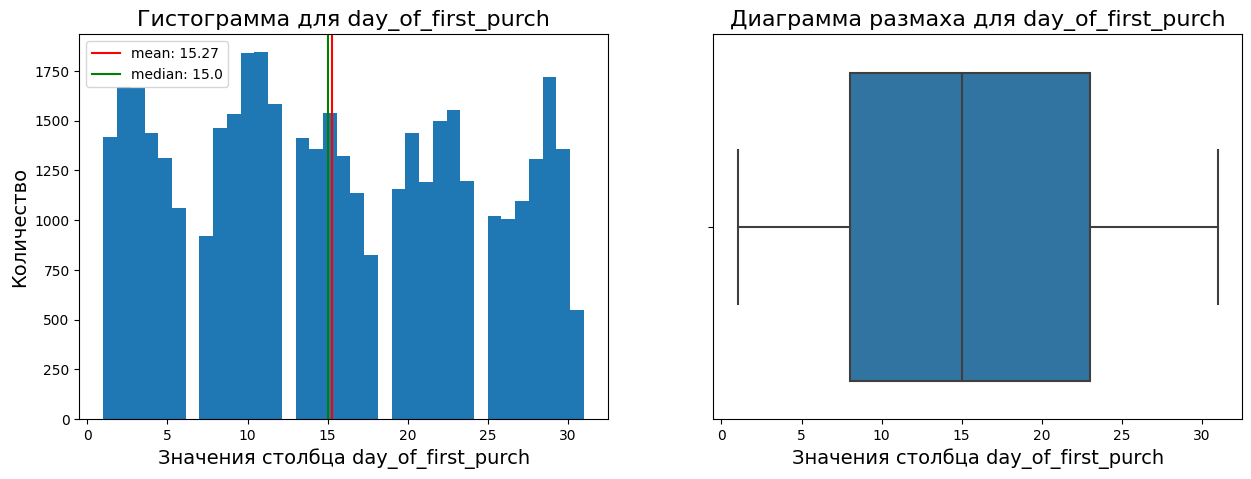

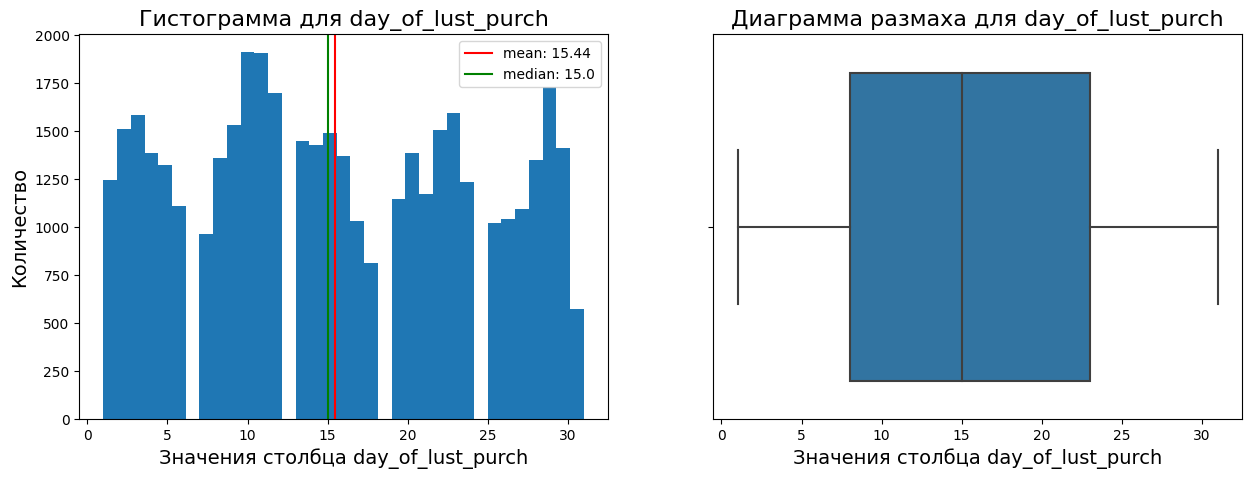

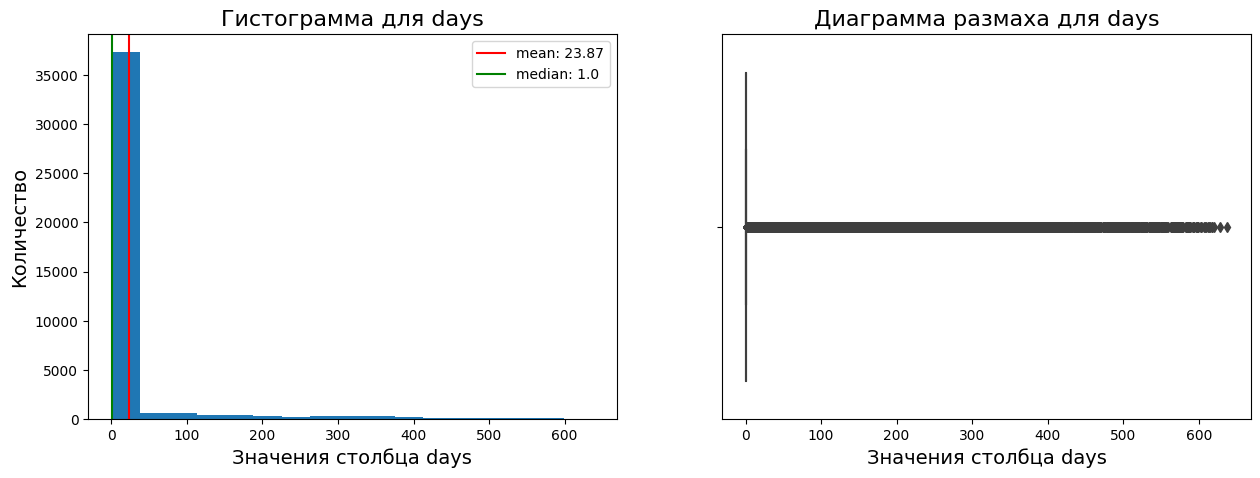

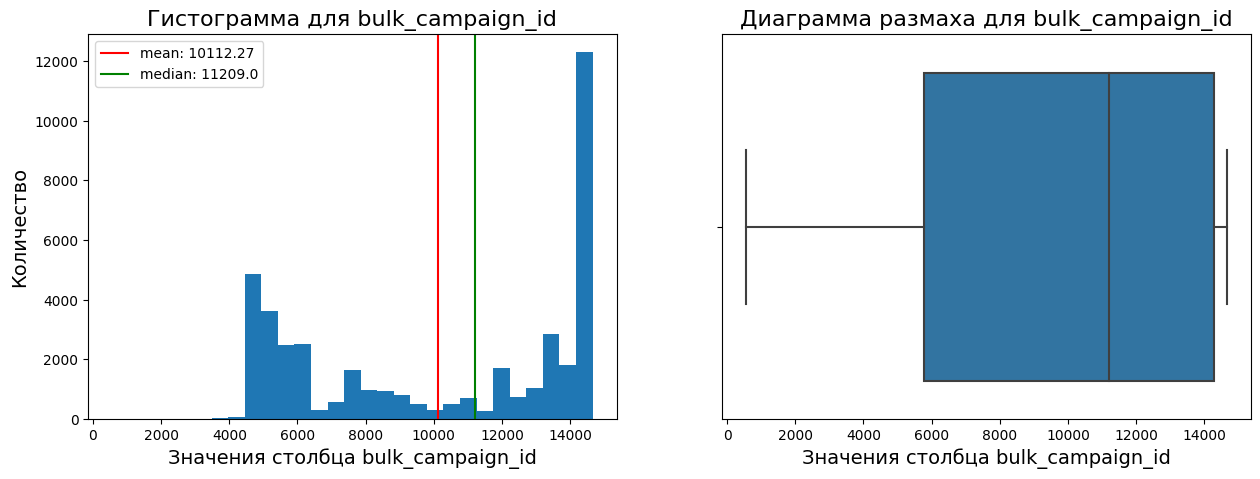

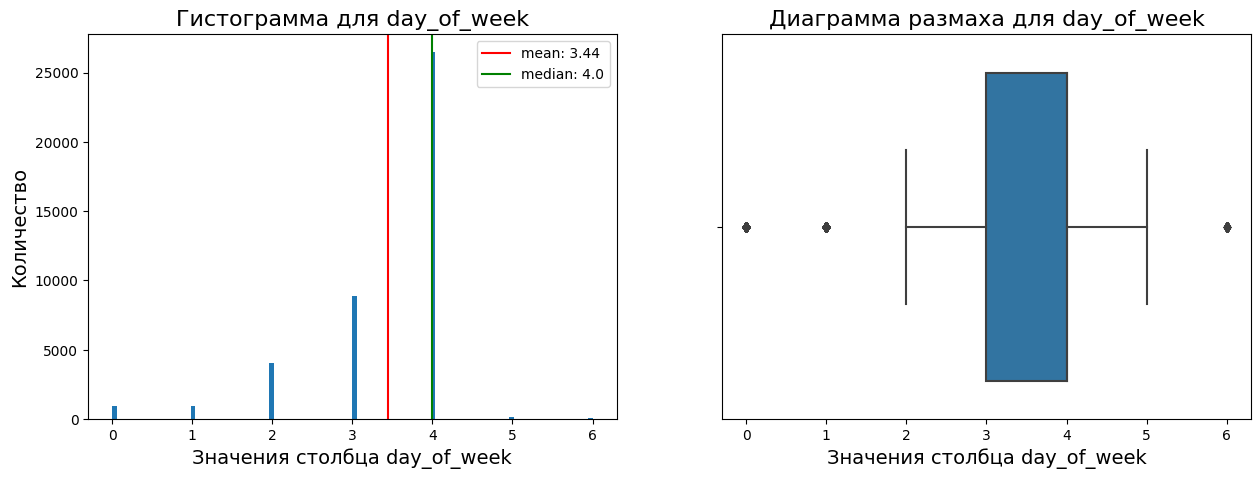

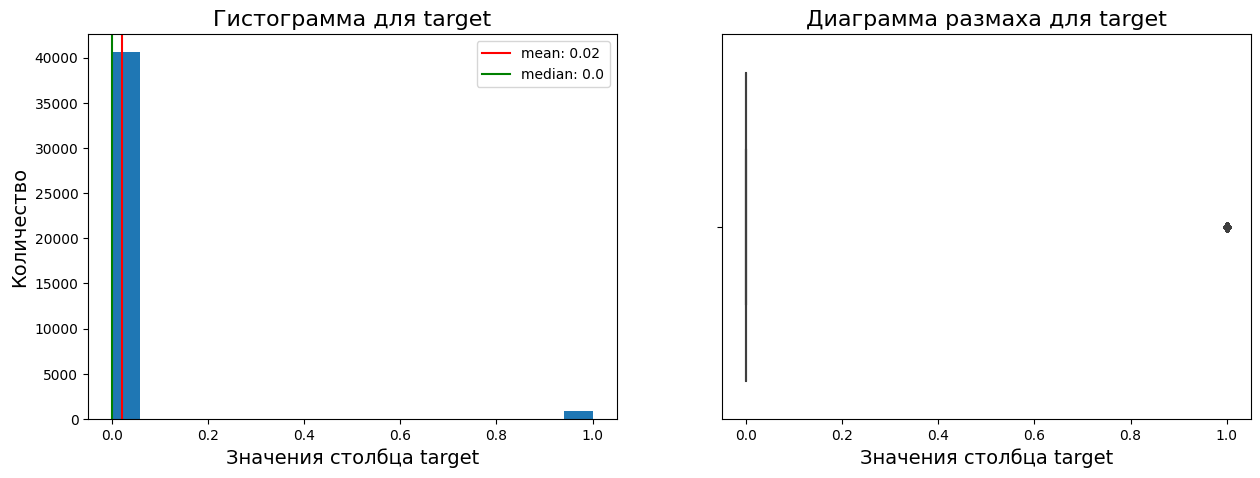

In [92]:
# рапсределение колличественных признаков
num_col = df.select_dtypes(include='number').columns.tolist() # спиок числовых признаков 

for col in num_col:
    hist_box(df, col)

- Столбец *total_price* - распределение сильно скошено вправо с длинным хвостом больших значений. Значения рапределились от 1 до 122772. Между 25 и 75 перцентилем значения от 1172.5 до 3924.5. Значения выше 10000 можно считать выбросами.

- Столбец *quantity* - распределение сильно скошено вправо с длинным хвостом больших значений. Значения рапределились от 1 до 131. Между 25 и 75 перцентилем значения от 1 до 4. Значения выше 10 можно считать выбросами.

- Столбец *mean_price* - распределение скошено вправо с хвостом больших значений. Значения рапределились от 0,2 до 6450. Между 25 и 75 перцентилем значения от 459.6 до 1549. Значения выше 3100 можно считать выбросами.

- Столбец *favorite_first_cat* - категориальный столбец, с целочисленными значениями от 1 до 6060. (8 уникальных)

- Столбец *favorite_second_cat* - категориальный столбец, с целочисленными значениями от 12 до 6059. (29 уникальных)

- Столбец *favorite_third_cat* - категориальный столбец, с целочисленными значениями от 38 до 6309. (279 уникальных)

- Столбец *favorite_fourth_cat* - категориальный столбец, с целочисленными значениями от 387 до 6296. (715 уникальных)

- Столбец *favorite_fifth_cat* - категориальный столбец, с целочисленными значениями от 467 до 999. (2 уникальных)

- Столбец *year_of_lust_purch* - категориальный столбец, с целочисленными значениями 2022 2023 2024. 

- Столбец *month_of_lust_purch* - категориальный столбец, с целочисленными значениями от 1 до 12. 

- Столбец *day_of_lust_purch* - категориальный столбец, с целочисленными значениями от 1 до 31. 	

- Столбец *days* - распределение сильно скошено вправо с длинным хвостом больших значений. Значения рапределились от 1 до 637. Между 25 и 75 перцентилем значения от 1 до 1. Значения выше 1 можно считать выбросами.

- Столбец *bulk_campaign_id* - бимодальное распределение. выбросов нет.

- Столбец *day_of_week* - категориальный столбец, с целочисленными значениями от 1 до 7. 	

- Столбец *target* - целевой признак. 


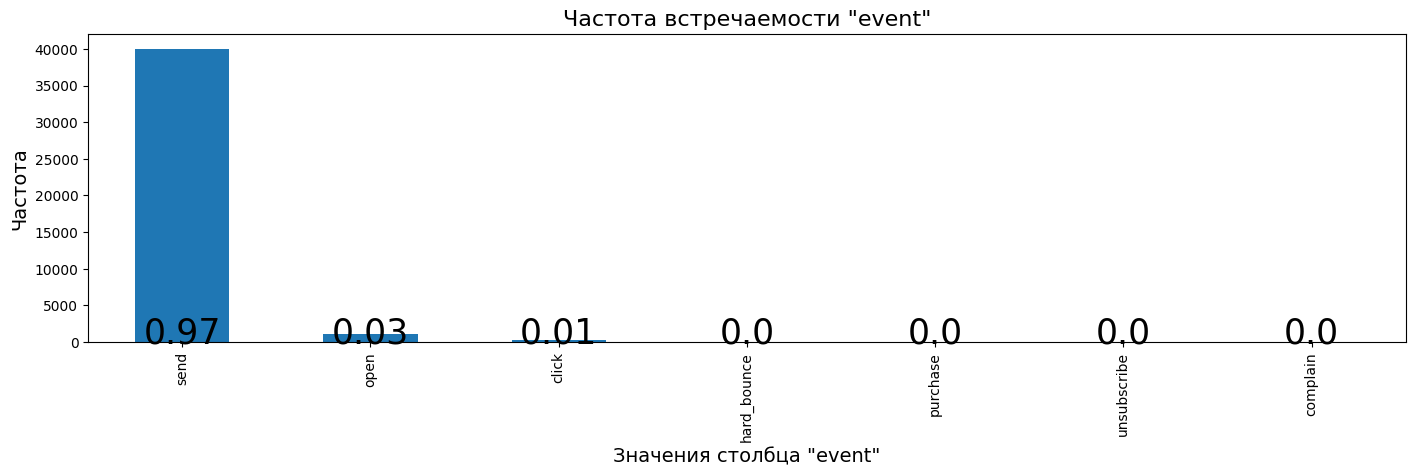

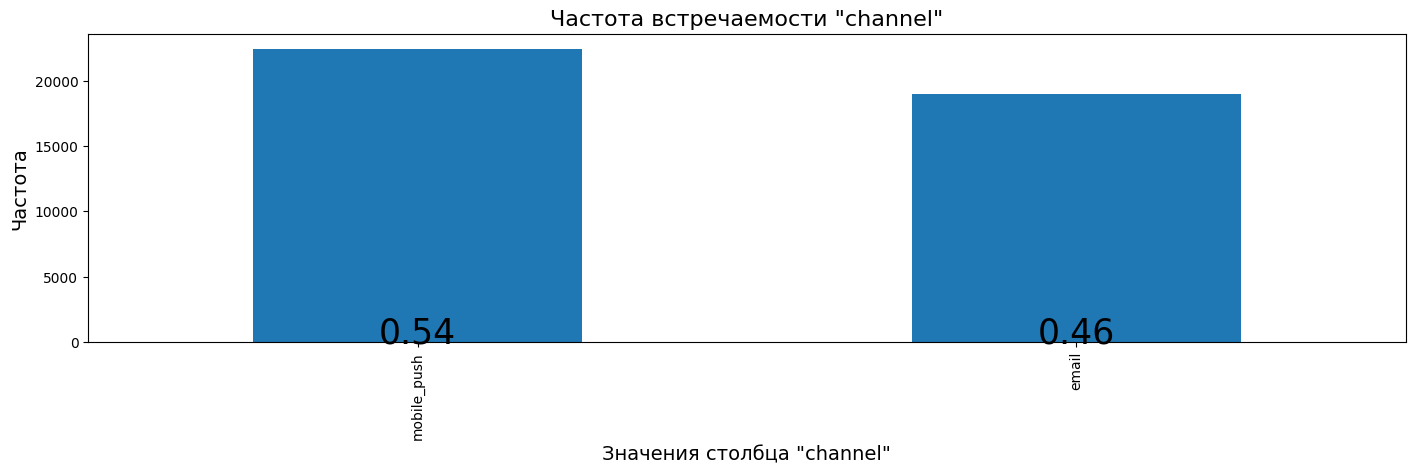

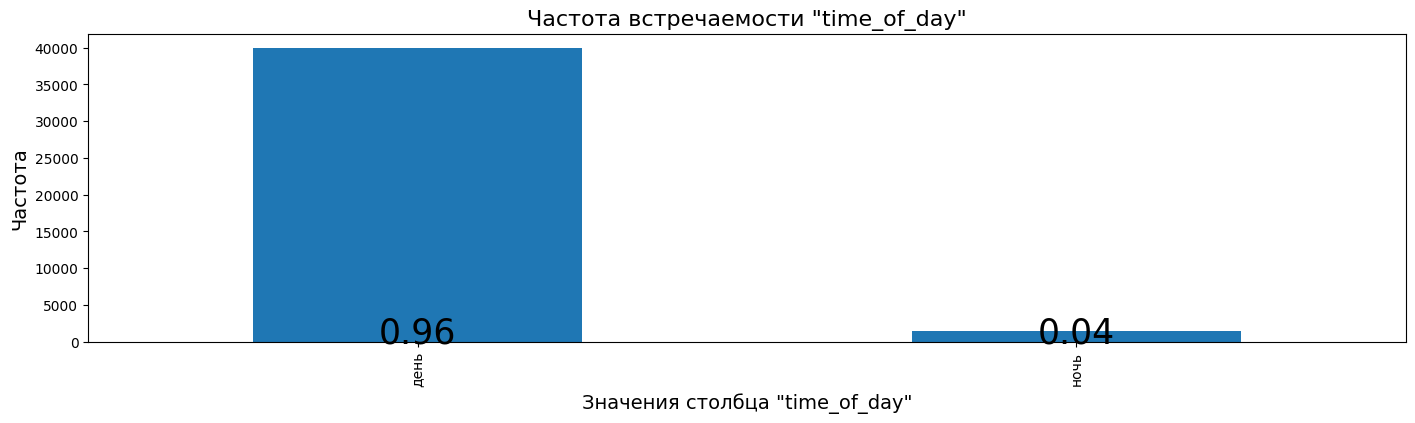

In [117]:
cat_col = df.select_dtypes(exclude='number').columns.to_list()

for col in cat_col:
    bar(df, col)

## Корреляционный анализ

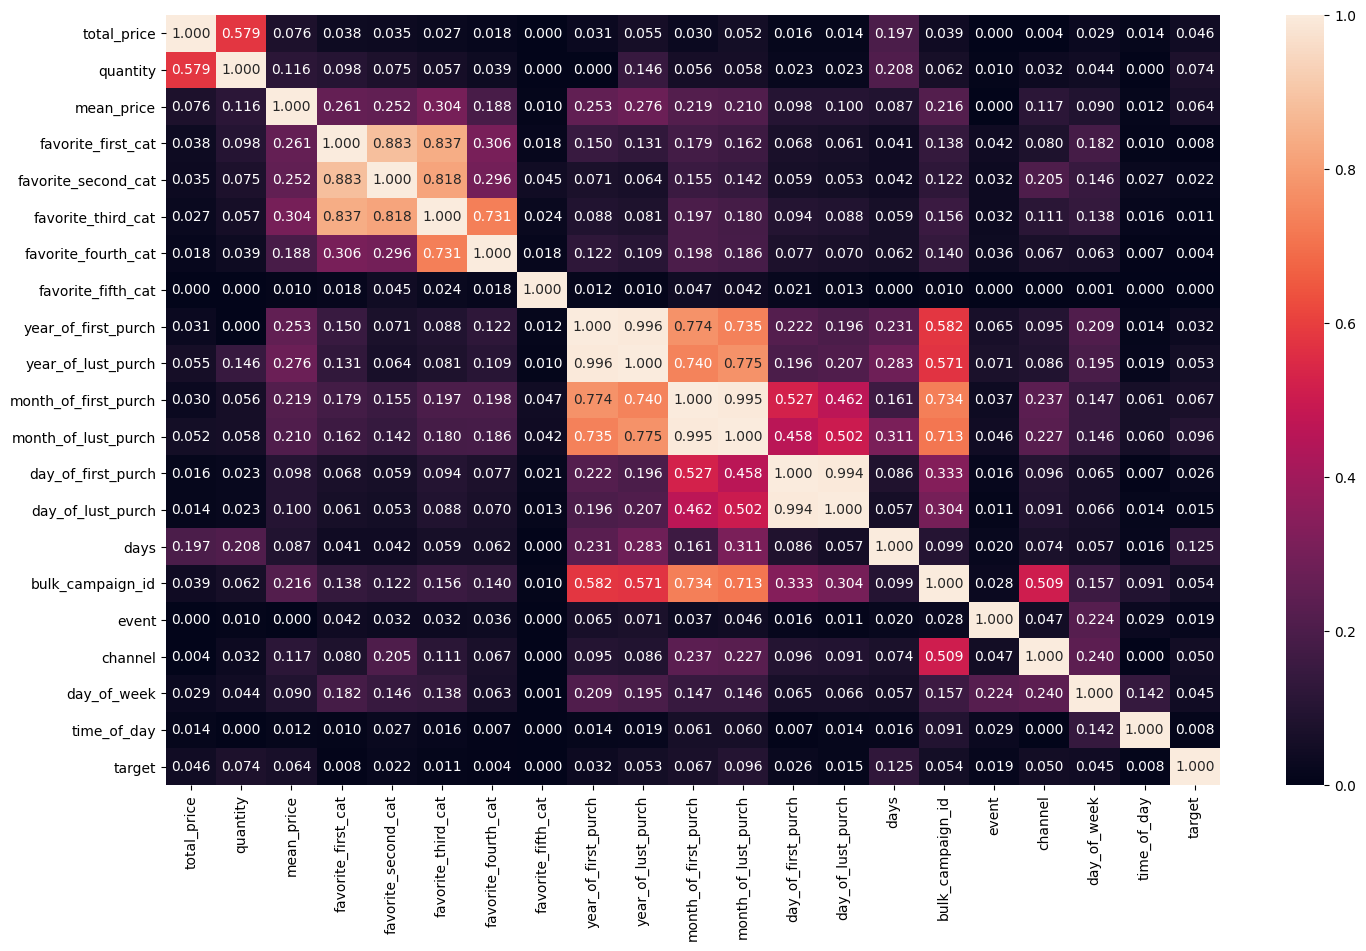

In [94]:
# построим тепловую карту коэфициэнтов корреляции
plt.figure(figsize = (17,10))
sns.heatmap(df.phik_matrix(verbose=False) , annot=True, fmt='.3f')
plt.xticks(rotation = 90); 

Наблюдается мультиколлинеарность между признаками обозначающими год месяц и день первой и последней покупки, удалим ряд признаков касающихся последних покупок.

In [95]:
df = df.drop(columns=['year_of_first_purch', 'month_of_first_purch', 'day_of_first_purch'])

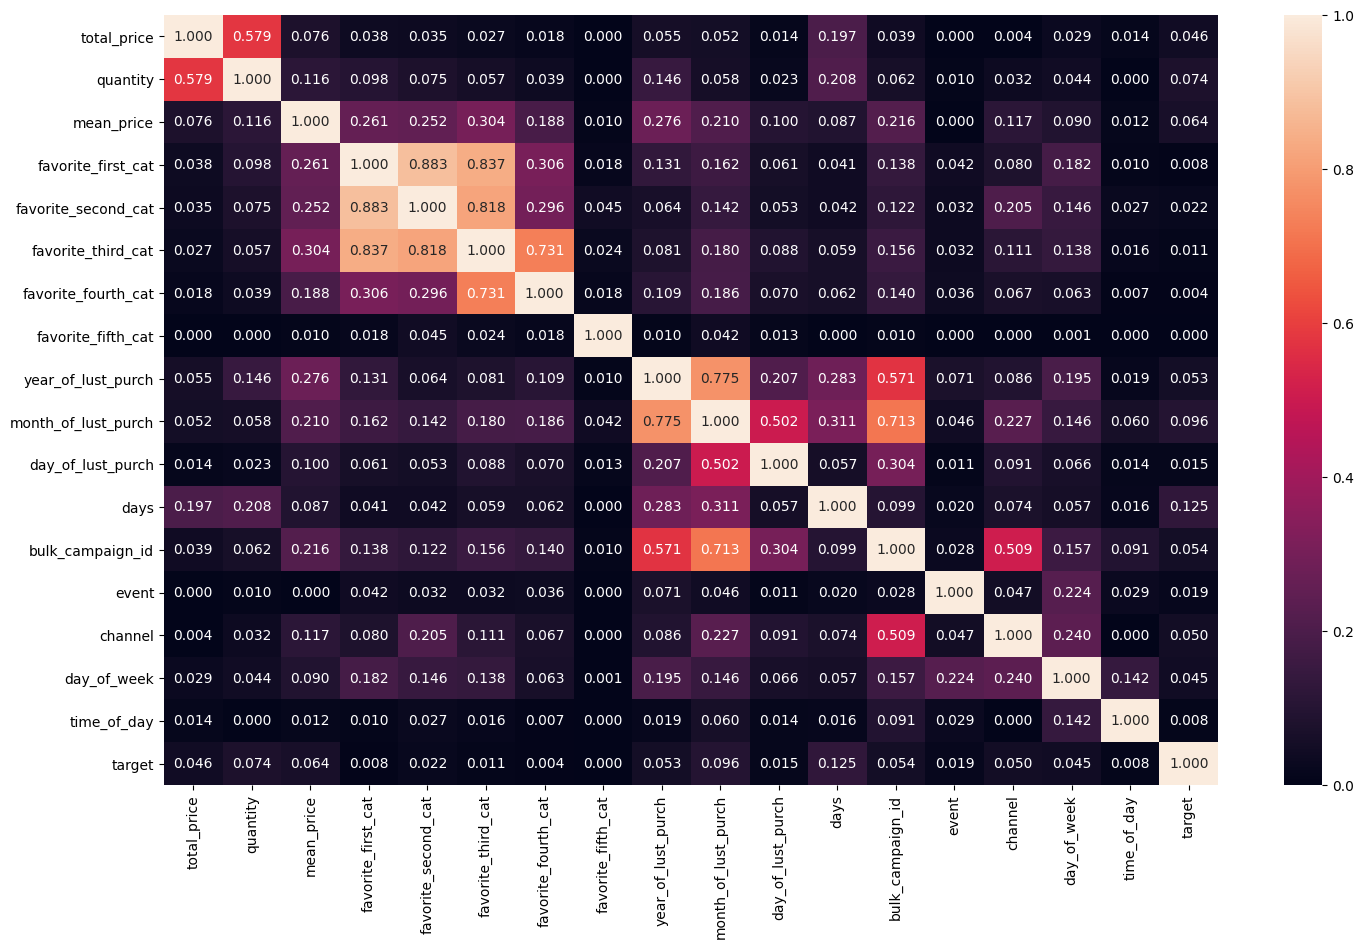

In [96]:
# построим тепловую карту коэфициэнтов корреляции
plt.figure(figsize = (17,10))
sns.heatmap(df.phik_matrix(verbose=False) , annot=True, fmt='.3f')
plt.xticks(rotation = 90); 

Корреляции с целевым у входящих признаков почти нет

## Обучение моделей

In [97]:
# определим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [98]:
# разделим данные на тренировочную и тестовую выборки
X = df.drop('target', axis=1)
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31061, 17)
(31061,)
(10354, 17)
(10354,)


In [99]:
num_col = X.select_dtypes(include='number').columns.to_list()
cat_col = X.select_dtypes(exclude='number').columns.to_list()

In [123]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)

In [124]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('num', StandardScaler(), num_col)    
    ], 
    remainder = 'passthrough'
)

In [140]:
pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor),
    ('adasyn', ADASYN(random_state=RANDOM_STATE)),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)


In [149]:
param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 8),
        'models__p': range(1,3),
        'preprocessor__num': [StandardScaler(), 'passthrough']   
    },
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],  
        'models__min_samples_leaf': [1, 3],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    # словарь для модели GradientBoostingClassifier(random_state=RANDOM_STATE)
    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__learning_rate': [0.05, 0.1], 
        'models__max_depth': [3, 5],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 4, 10],
        'models__penalty': ['l1', 'l2'],
        'models__solver': ['liblinear', 'saga'],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0, thread_count=-1)],
        'models__iterations': [100, 200, 300, 500],  # Количество деревьев
        'models__depth': [4, 6, 8, 10],  # Глубина деревьев
        'models__learning_rate': [0.01, 0.03, 0.05, 0.1],  # Скорость обучения
        'models__l2_leaf_reg': [1, 3, 5, 7],  # Коэффициент L2-регуляризации
        'models__border_count': [32, 64, 128],  # Количество границ для разделения
        'models__random_strength': [0.5, 1, 2],  # Интенсивность рандомизации
    }
]

In [150]:
# поиск оптимальной модели
rs = RandomizedSearchCV(
    pipe_final, 
    param_distributions_catboost,
    cv=5,
    scoring='roc_auc', 
    n_jobs=-1,
    random_state=RANDOM_STATE
) 
# обучение модели на тренировочных данных
rs.fit(X_train, y_train) 


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['event',
                                                                                'channel',
                                                                                'time_of_day']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['total_price',
                                                                                'quanti...
                   n_jobs=-1,
                   param_distributions={'models': [<catboost.core.CatBoostClassifier object at 0x000001BC000364C0>],
                                        'models__border_count': [32, 64, 128],
                                        'models__depth': [4, 6, 8, 10],
                                        'models__iterations': [100, 200, 300,
                                                               500],
                                        'models__l2_leaf_reg': [1, 3, 5, 7],
                                        'models__learning_rate': [0.01, 0.03,
                                                                  0.05, 0.1],
                                        'models__random_strength': [0.5, 1, 2]},
                   random_state=42, scoring='roc_auc')

**ROC-AUC** находит баланс между долей положительных объектов, правильно предсказанных положительными и долей отрицательных объектов, неверно предсказанных положительными, при этом если в будущем компания решит изменить порог классификации это не повлияет на метрику так как она находит баланс при любых возможных порогах классификации.

In [151]:
print('Метрика ROC-AUC для лучшей модели:', round(rs.best_score_, 3)) 
print('\nЛучшая модель и её параметры:\n\n', rs.best_params_) 

Метрика ROC-AUC для лучшей модели:
 0.6824

Лучшая модель и её параметры:

 {'models__random_strength': 2, 'models__learning_rate': 0.01, 'models__l2_leaf_reg': 7, 'models__iterations': 200, 'models__depth': 8, 'models__border_count': 64, 'models': <catboost.core.CatBoostClassifier object at 0x000001BC000364C0>}


In [152]:
y_pred = rs.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred), 3)}')

Метрика ROC-AUC на тестовой выборке: 0.7216


c:\Anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Вывод этапа обучение моделей:

На данном этапе разделили данные на тренировочную и тестовую выборки, категориальные признаки закодировали с помощью OneHotEncoder, числовые масштабировали с помощью StandardScaler, провели оверсэплинг с помощью ADASYN, и  с помощью RandomizedSearchCV определили лучшую модель и ее параметры. Ею оказалась модель CatBoostClassifier(random_strength = 2, learning_rate = 0.01, l2_leaf_reg = 7, iterations = 200, depth = 8, border_count = 64) Метрика ROC-AUC на тестовой выборке: 0.722

## Анализ важности признаков

c:\Anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
100%|===================| 10315/10354 [04:15<00:00]        

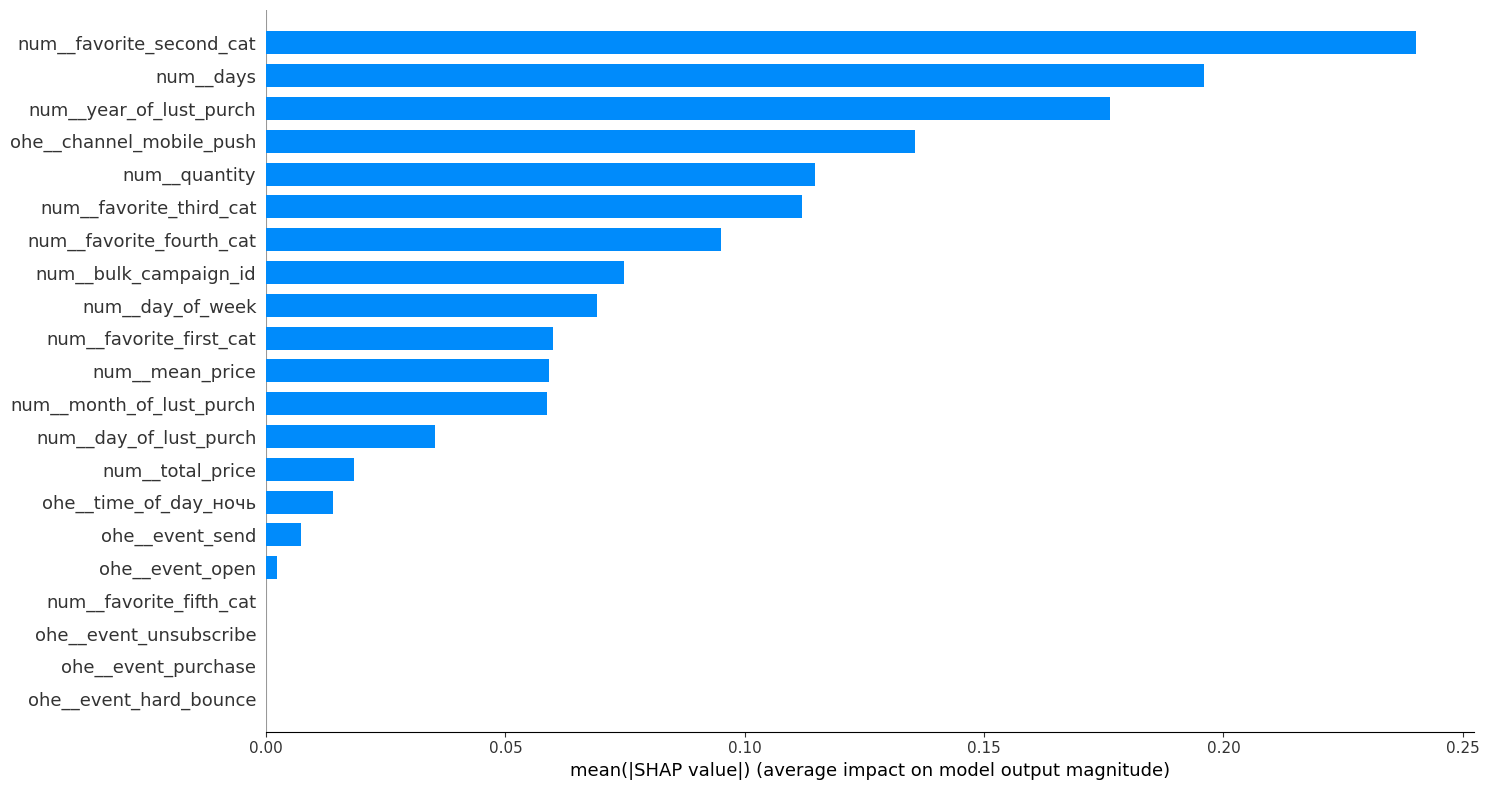

In [153]:
X_train_encoded = rs.best_estimator_['preprocessor'].fit_transform(X_train)

explainer = shap.Explainer(rs.best_estimator_['models'], X_train_encoded)

X_test_encoded = rs.best_estimator_['preprocessor'].transform(X_test)

feature_names = rs.best_estimator_['preprocessor'].get_feature_names_out()

X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names)
 
shap_values = explainer(X_test_encoded)
 
shap.summary_plot(shap_values, plot_type='bar', max_display=30,  plot_size=(15,8))


In [155]:
s = df.columns.to_list()
s

['total_price',
 'quantity',
 'mean_price',
 'favorite_first_cat',
 'favorite_second_cat',
 'favorite_third_cat',
 'favorite_fourth_cat',
 'favorite_fifth_cat',
 'year_of_lust_purch',
 'month_of_lust_purch',
 'day_of_lust_purch',
 'days',
 'bulk_campaign_id',
 'event',
 'channel',
 'day_of_week',
 'time_of_day',
 'target']

Сильнее всего на прогноз модели влияют 7 признаков **num_favorite_second_cat // num_days // num_year_of_lust_purch // ohe_channel_mobile_push**
 
признаки **num__quantity // num__favorite_third_cat // num__favorite_fourth_cat// num__bulk_campaign_id// num__day_of_week** в меньшей степени влияют на прогноз модели.

признаки **num__favorite_first_cat // num__mean_price // num__month_of_lust_purch // num__day_of_lust_purch// num__total_price// ohe_time_of_day_ночь** слабо влияют на прогноз модели


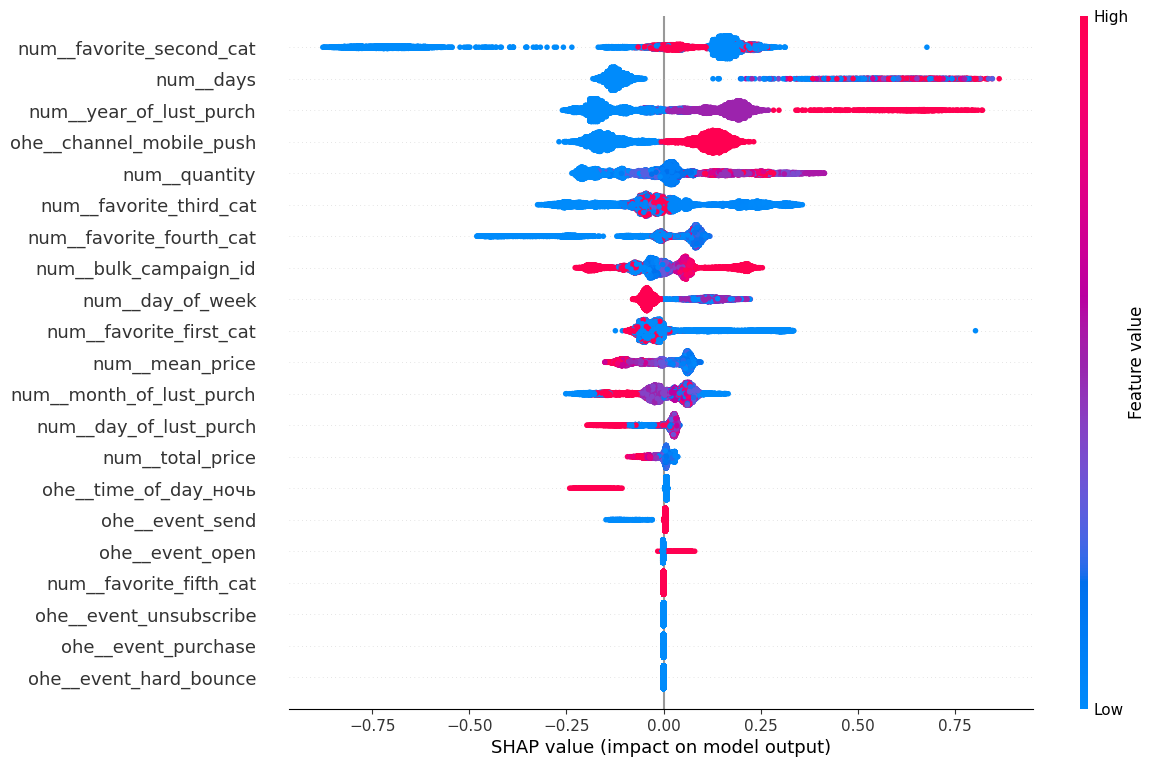

In [154]:
shap.plots.beeswarm(shap_values, max_display=30, plot_size=(12,9))

**num_days** - чем меньше колличество дней тем больше модель склоняется к предсказанию 0(не совершит покупку)

**num_year_of_lust_purch** - чем больше год совершения покупки тем тем больше модель склоняется к предсказанию 1(совершит покупку)

**num__quantity** - чем меньше колличество покупок тем больше модель склоняется к предсказанию 0(не совершит покупку)

**num__mean_price** чем выше средняя цена покупки тем больше модель склоняется к предсказанию 0(не совершит покупку)



## Общий вывод

Задачей проекта было с помощью модели машинного обучения предсказать вероятность покупки в течение 90 дней.

Исходные данные представляли собой три таблицы с информацией о покупках, маркетиноговых сообщениях и с целевым показателем.
Была проведена предобработка данных, удалены дубликаты, созданы дополнительные признаки на основе существующих. Так же была проведен корреляционный анализ, на основе которго были удалены лишние столбцы с мультиколлинеарностью.

На этапе обучения моделей данные были закодированы и масштабированы, избавлены от дисбаланса классов.

Лучшей моделью стала CatBoostClassifier, метрика ROC-AUC на тестовой выборке: 0.722

На основе анализа важности признаков могу дать рекомендации:

Для увеличения доли клиентов готовых совершить покупку в течении 90 дней 
- маркетиногвые сообщения стоит отправлять пуш уведомлением в ночные часы (у многих людей в ночные часы стоит режим не беспокоить, так что это не оотолкнет клиентв) утром увидев оповещение они уделят ему больше внимания пока голова еще не занята работой
- мотивировать клиентов совершать больше мелких покупок, это формирует привязанность к сервису


In [157]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
